In [199]:
%reset -f

In [200]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
from sklearn import svm, datasets, feature_selection, cross_validation
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, mutual_info_score, normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV,chi2, f_oneway
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn import feature_selection
from sklearn import cross_validation
from sklearn.externals import joblib
from sklearn import cross_validation
from sklearn import preprocessing
from multiprocessing import Pool
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import logging.config
import pandas as pd
import numpy as np 
import datetime
import csv
import os
import pickle
%matplotlib inline
import seaborn as sns
np.set_printoptions(suppress=True)
plt.style.use('bmh')

#sns.axes_style("darkgrid")
#sns.set(rc={'axes.facecolor':'white'})
#sns.set(rc={'grid.color':'black'})
#sns.set(rc={'axes.edgecolor':'black'})
#sns.set_style("ticks")
#sns.set(rc={'axes.facecolor':'#EAEAF2'}) #initial grey color

import sys
sys.path.insert(1, "/home/aegle/projects/myosa/src/")
from TypeFeatImputer import TypeFeatImputer
from i_score_parallel import i_score

### 1.Load train & test data

In [201]:
datafilename = os.path.join('resources','data_partition_cl0_short_3m_1m_monit_14012016.pkl')


#Load Train & test data
f = file(datafilename,"rb")
X_train = np.load(f).astype(float)
y_train = np.load(f).astype(int)
X_test = np.load(f).astype(float)
y_test = np.load(f).astype(int)
columns = np.load(f)
tr_codes = np.load(f)
ts_codes = np.load(f)
feat_types = np.load(f)
feat_types = dict(feat_types.tolist())
f.close()

#Join data
X_all = np.vstack((X_train,X_test))
y_all = np.hstack((y_train, y_test)).reshape(-1,1)
data = np.hstack((X_all,y_all.reshape(-1,1)))
all_codes = np.hstack((tr_codes,ts_codes))

print columns
df_all = pd.DataFrame(data, columns=columns)

print X_all.shape, y_all.shape, all_codes.shape
print X_train.shape, X_test.shape
print df_all.shape
print np.sum(y_test == 0), np.sum(y_test == 1)


['GENERO' 'ACTIVO' 'JUBILADO' 'EDAD' 'FUMA' 'FUMA_PAQ_ANY' 'FUMA_EX_ANYS'
 'ALCOHOL' 'ALCOHOL_GR_DIA' 'CAFES_DIA' 'DEPRESION' 'ANSIEDAD' 'HTA'
 'CARDIOPATIA' 'ENF_RESP' 'DIABETES' 'OBESIDAD' 'DISLIPEMIA'
 'OBSTR_NASAL_CRON' 'RONCA' 'SUE_REP' 'CRISIS_ASF' 'NICTURIA' 'APNEAS_PRES'
 'CEFALEA' 'SOMN_DIURN' 'DESPERTAR_NOCT' 'TRAST_CONC' 'IRR_APAT_DEPR'
 'INSOMNIO' 'ACT_MOTR_NOCT' 'SEN_SUE_REAL_DORM' 'SUE_INT_PIROSIS'
 'DISM_DESEO_SEX' 'IECAS' 'DIURETICOS' 'ANTIAGREG' 'ANTIACID' 'HIPOLIPEM'
 'BDZ' 'TIEMP_SUENO' 'IAH' 'TIEMPOSAT<90%' 'IND_DESAT' 'TALLA' 'IMC'
 'CIRC_CUELLO' 'MEDIA_TAS' 'MEDIA_TAD' 'Sat O2' 'PRESS_CPAP' 'EPWORTH'
 'EUROQOL' 'VISUAL' 'HORAS_USO_TOT_1' 'HORAS_USO_MED_NOCHE_1'
 'AL_IRR_CUT_MASC_1' 'BOCA_SECA_1' 'MEDIA_TAS_1' 'MEDIA_TAD_1' 'EPWORTH_1'
 'EUROQOL_1' 'VISUAL_EUROQOL_1' 'HORAS_USO_MED_NOCHE_3' 'BOCA_SECA_3'
 'MEDIA TAS_3' 'MEDIA TAD_3' 'EPWORTH_3' 'EUROQOL_3' 'VISUAL EUROQOL_3'
 'LABEL']
(42, 70) (42, 1) (42,)
(29, 70) (13, 70)
(42, 71)
6 7


In [202]:
print df_all.shape
print len(feat_types)
print len(columns)
print columns

(42, 71)
72
71
['GENERO' 'ACTIVO' 'JUBILADO' 'EDAD' 'FUMA' 'FUMA_PAQ_ANY' 'FUMA_EX_ANYS'
 'ALCOHOL' 'ALCOHOL_GR_DIA' 'CAFES_DIA' 'DEPRESION' 'ANSIEDAD' 'HTA'
 'CARDIOPATIA' 'ENF_RESP' 'DIABETES' 'OBESIDAD' 'DISLIPEMIA'
 'OBSTR_NASAL_CRON' 'RONCA' 'SUE_REP' 'CRISIS_ASF' 'NICTURIA' 'APNEAS_PRES'
 'CEFALEA' 'SOMN_DIURN' 'DESPERTAR_NOCT' 'TRAST_CONC' 'IRR_APAT_DEPR'
 'INSOMNIO' 'ACT_MOTR_NOCT' 'SEN_SUE_REAL_DORM' 'SUE_INT_PIROSIS'
 'DISM_DESEO_SEX' 'IECAS' 'DIURETICOS' 'ANTIAGREG' 'ANTIACID' 'HIPOLIPEM'
 'BDZ' 'TIEMP_SUENO' 'IAH' 'TIEMPOSAT<90%' 'IND_DESAT' 'TALLA' 'IMC'
 'CIRC_CUELLO' 'MEDIA_TAS' 'MEDIA_TAD' 'Sat O2' 'PRESS_CPAP' 'EPWORTH'
 'EUROQOL' 'VISUAL' 'HORAS_USO_TOT_1' 'HORAS_USO_MED_NOCHE_1'
 'AL_IRR_CUT_MASC_1' 'BOCA_SECA_1' 'MEDIA_TAS_1' 'MEDIA_TAD_1' 'EPWORTH_1'
 'EUROQOL_1' 'VISUAL_EUROQOL_1' 'HORAS_USO_MED_NOCHE_3' 'BOCA_SECA_3'
 'MEDIA TAS_3' 'MEDIA TAD_3' 'EPWORTH_3' 'EUROQOL_3' 'VISUAL EUROQOL_3'
 'LABEL']


### 2. ALL data exploration & visualization

#### Null values

                              0  1
AL_IRR_CUT_MASC_1      0.095238  4
APNEAS_PRES            0.023810  1
BOCA_SECA_1            0.095238  4
BOCA_SECA_3            0.047619  2
DISM_DESEO_SEX         0.095238  4
EPWORTH_1              0.095238  4
EPWORTH_3              0.047619  2
EUROQOL_1              0.119048  5
EUROQOL_3              0.071429  3
HORAS_USO_MED_NOCHE_1  0.095238  4
HORAS_USO_MED_NOCHE_3  0.047619  2
HORAS_USO_TOT_1        0.095238  4
MEDIA TAD_3            0.071429  3
MEDIA TAS_3            0.095238  4
MEDIA_TAD_1            0.119048  5
MEDIA_TAS_1            0.119048  5
NICTURIA               0.023810  1
OBSTR_NASAL_CRON       0.023810  1
TIEMP_SUENO            0.023810  1
VISUAL EUROQOL_3       0.071429  3
VISUAL_EUROQOL_1       0.119048  5
(21, 2)


<function matplotlib.pyplot.show>

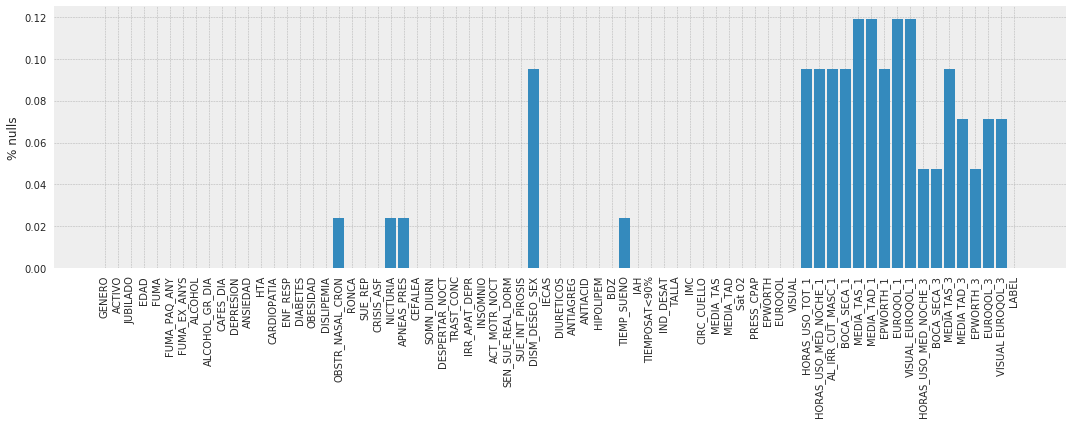

In [203]:
dfNull = np.sum(df_all.isnull()) / float(df_all.shape[0])
dfNullAll = pd.concat([dfNull[dfNull>0],np.sum(df_all.isnull())], axis=1)
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False]
print dfNullAll[dfNullAll.iloc[:,0].isnull() == False].shape

plt.figure(figsize=(15,6))
plt.bar(range(dfNull.shape[0]),dfNull.iloc[:])
plt.xticks(range(dfNull.shape[0]),dfNull.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Categoric/Numeric columns

In [204]:
catCols = []
reducedCols = columns[:-1]

for i in range(len(columns)-1):

    if feat_types[columns[i]] == 'object' \
        or columns[i] in ("RONCA","SUE_REP","CRISIS_ASF","NICTURIA","APNEAS_PRES","CEFALEA",
                "SOMN_DIURN","DESPERTAR_NOCT","TRAST_MEM","TRAST_CONC","IRR_APAT_DEPR"):
        catCols.append(1)
        
        #print columns[i], df_all[columns[i]].unique()
        #df_all[columns[i]] = df_all[columns[i]].astype(int)
    else:
        catCols.append(0)
catCols = np.array(catCols)

print "Cat cols:", np.sum(catCols==1)
print "Num cols:", np.sum(catCols==0)
print len(reducedCols)

Cat cols: 38
Num cols: 32
70


#### Impute NaN

In [205]:
df_all.loc[:,"EUROQOL_3"].values

array([ 1.     ,      nan,  0.7902 ,  1.     ,  0.7601 ,  1.     ,
        0.7986 ,  1.     ,  0.6493 ,  0.73901,  1.     ,  0.217  ,
        0.7902 ,  1.     ,  1.     ,  0.5442 ,  1.     ,  0.7005 ,
            nan,  1.     ,  0.73901,  1.     ,  0.7089 ,  1.     ,
        0.7986 ,  0.73901,  1.     ,  0.7005 ,  1.     ,  1.     ,
        1.     ,  0.5442 ,  0.2727 ,  0.7902 ,      nan,  1.     ,
        1.     ,  0.7902 ,  0.7601 ,  0.7986 ,  1.     ,  1.     ])

In [206]:
#Transform discrete
imputer = TypeFeatImputer(catCols, reducedCols)
imputer.fit(df_all.iloc[:,:-1].values.astype(float),df_all.iloc[:,-1].values.astype(float))

dfImputed = imputer.transform(df_all.iloc[:,:-1].values.astype(float))
dfImputed = pd.DataFrame(dfImputed,columns=df_all.columns[:-1])

print "Total NaN before imputation:", np.sum(np.isnan(df_all.values.astype(float)))
print "Total NaN after imputation:", np.sum(np.sum(np.isnan(dfImputed.astype(float))))
print df_all.columns[-1]
print df_all.iloc[:,-1].values

Total NaN before imputation: 67
Total NaN after imputation: 0
LABEL
[ 1.  0.  0.  1.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  1.
  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  0.
  0.  1.  0.  1.  1.  1.]


#### Normality test

In [208]:
import scipy.stats as stats

arrNorm = []
for i,rv in enumerate(df_all.columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]

    #normalize
    #if catCols[i] == 0:
        #cleanIc = np.log2(cleanIc.astype(float))    
        #normer = Normalizer()
        #normer.fit(cleanIc.astype(float))
        #cleanIc = normer.transform(cleanIc.astype(float)).T.flatten()
    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if catCols[i] == 1 else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

dfNorm[np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no")][["variable","f_val","p_value"]]

(70, 5)
Normal features: 24
Normal numerical features: 20
Normal categorical features: 4
No Normal features: 46
No Normal numerical features: 12
No Normal categorical features: 34


,variable,f_val,p_value
5,FUMA_PAQ_ANY,26.8084,0.0
6,FUMA_EX_ANYS,26.2396,0.0
8,ALCOHOL_GR_DIA,46.7598,0.0
42,TIEMPOSAT<90%,20.0034,0.0
43,IND_DESAT,7.0876,0.0289
49,Sat O2,22.1242,0.0
52,EUROQOL,6.2733,0.0434
55,HORAS_USO_MED_NOCHE_1,6.1217,0.0468
66,MEDIA TAD_3,7.1724,0.0277
67,EPWORTH_3,23.0853,0.0


#### Distribution Numeric features

EDAD
Unique values: 29
p-value: 0.473779508033
Normal: True
Mean: 56.9285714286 std: 12.4257659669


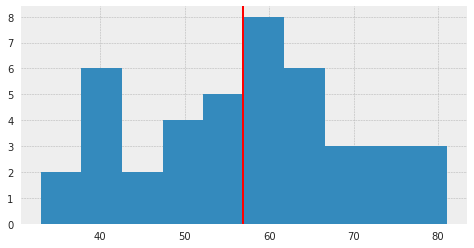

FUMA_PAQ_ANY
Unique values: 11
p-value: 1.50879486303e-06
Normal: False
Mean: 152.547619048 std: 249.854167216


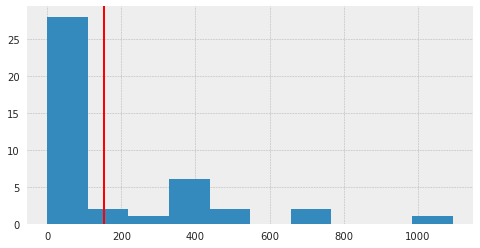

FUMA_EX_ANYS
Unique values: 12
p-value: 2.00515958455e-06
Normal: False
Mean: 2.69642857143 std: 5.47220675493


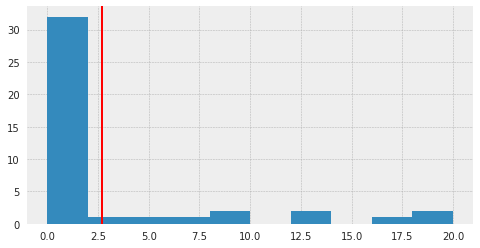

ALCOHOL_GR_DIA
Unique values: 8
p-value: 7.01827283906e-11
Normal: False
Mean: 4.34666666667 std: 9.13975894927


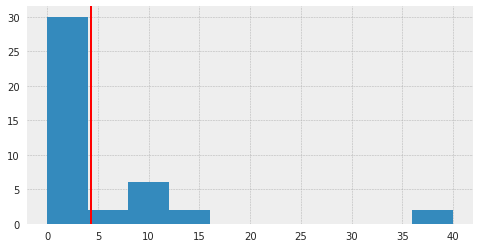

CAFES_DIA
Unique values: 7
p-value: 0.0789482447932
Normal: True
Mean: 1.35714285714 std: 1.28306605574


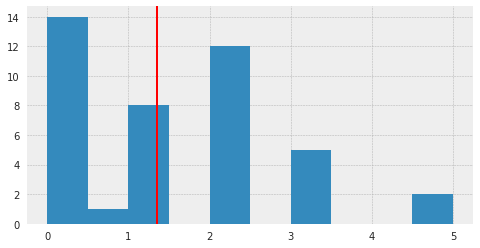

TIEMP_SUENO
Unique values: 40
p-value: 0.0593165215025
Normal: True
Mean: 389.756097561 std: 72.6972785525


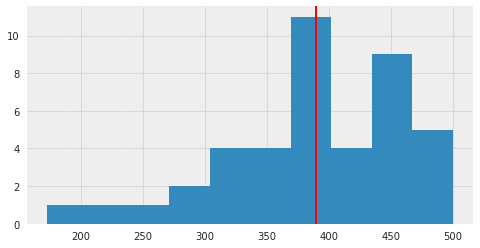

IAH
Unique values: 42
p-value: 0.190788101702
Normal: True
Mean: 53.1311904762 std: 20.7184994633


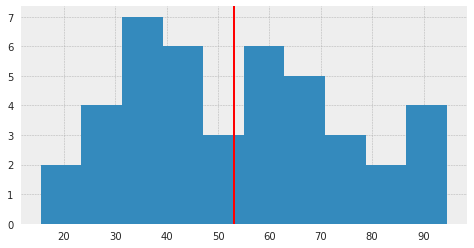

TIEMPOSAT<90%
Unique values: 37
p-value: 4.53235187487e-05
Normal: False
Mean: 65.3030952381 std: 74.6727674109


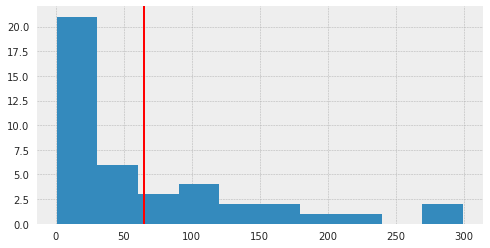

IND_DESAT
Unique values: 41
p-value: 0.0289030759687
Normal: False
Mean: 39.325 std: 25.1074142199


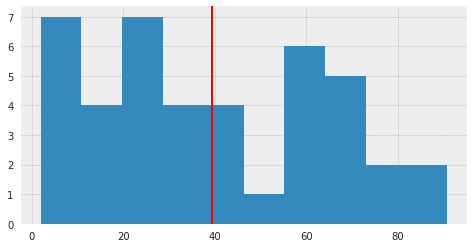

TALLA
Unique values: 24
p-value: 0.551824158919
Normal: True
Mean: 1.66833333333 std: 0.0977829634267


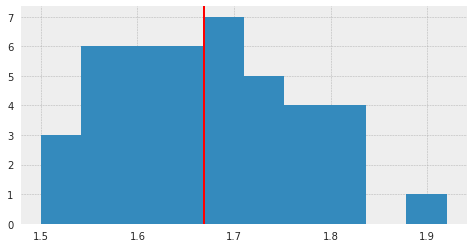

IMC
Unique values: 41
p-value: 0.210833665319
Normal: True
Mean: 33.8342857143 std: 6.38574347495


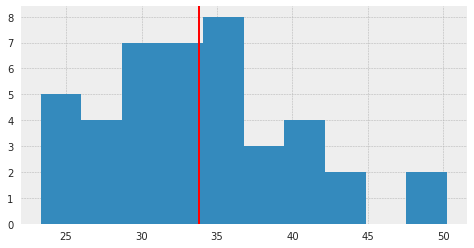

CIRC_CUELLO
Unique values: 15
p-value: 0.701025018709
Normal: True
Mean: 42.5238095238 std: 4.24958314616


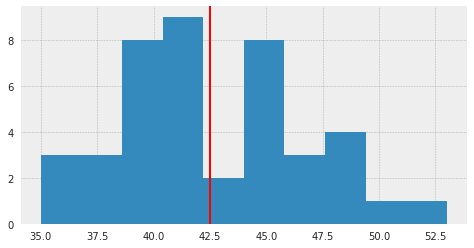

MEDIA_TAS
Unique values: 38
p-value: 0.654640617192
Normal: True
Mean: 137.607142857 std: 20.3731662085


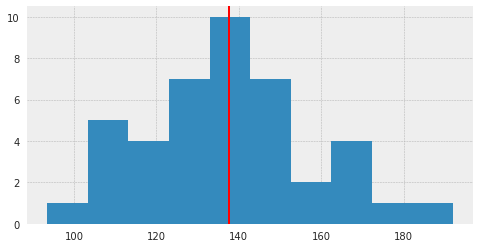

MEDIA_TAD
Unique values: 32
p-value: 0.117106687769
Normal: True
Mean: 87.0 std: 14.8038765837


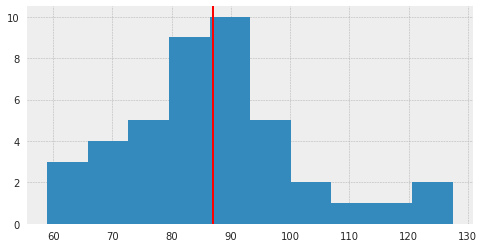

Sat O2
Unique values: 7
p-value: 1.56957562993e-05
Normal: False
Mean: 97.4285714286 std: 1.49829835453


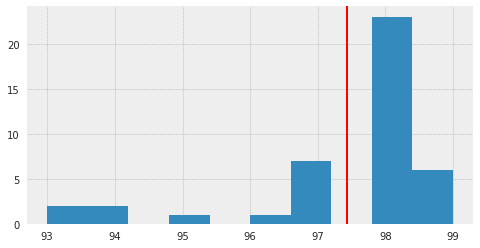

PRESS_CPAP
Unique values: 9
p-value: 0.631944751572
Normal: True
Mean: 10.9238095238 std: 1.15959958685


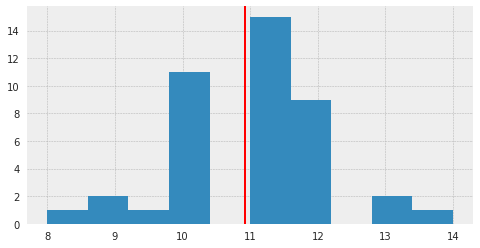

EPWORTH
Unique values: 19
p-value: 0.5007292619
Normal: True
Mean: 8.84285714286 std: 4.64789470299


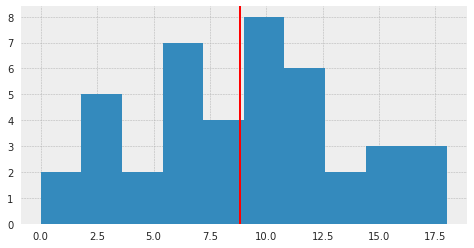

EUROQOL
Unique values: 16
p-value: 0.0434274208809
Normal: False
Mean: 0.787262142857 std: 0.217845228693


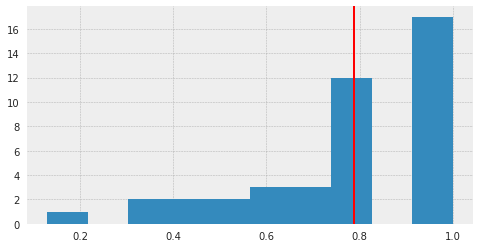

VISUAL
Unique values: 12
p-value: 0.767272513635
Normal: True
Mean: 58.119047619 std: 23.1673028836


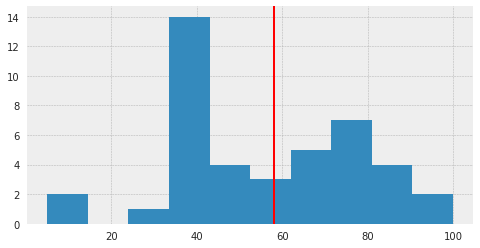

HORAS_USO_TOT_1
Unique values: 37
p-value: 0.237584449451
Normal: True
Mean: 217.684210526 std: 94.4291382752


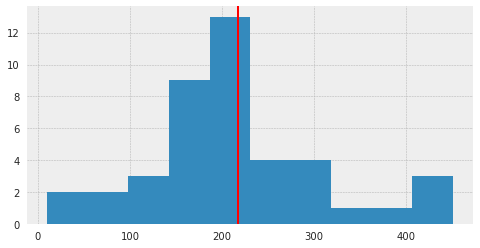

HORAS_USO_MED_NOCHE_1
Unique values: 17
p-value: 0.0468479390193
Normal: False
Mean: 5.43947368421 std: 1.63263437042


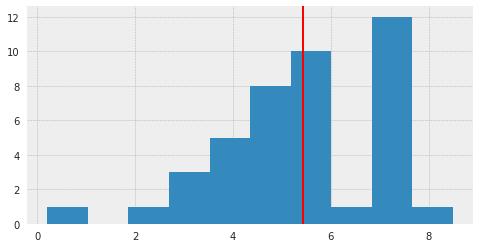

MEDIA_TAS_1
Unique values: 36
p-value: 0.233503191802
Normal: True
Mean: 133.040540541 std: 17.9954949317


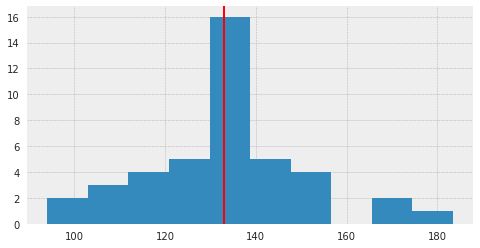

MEDIA_TAD_1
Unique values: 25
p-value: 0.149335034477
Normal: True
Mean: 82.4459459459 std: 11.6085886635


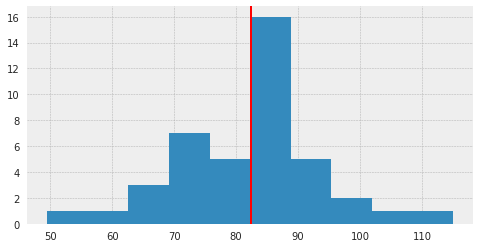

EPWORTH_1
Unique values: 18
p-value: 0.155472940551
Normal: True
Mean: 6.06842105263 std: 3.47810192238


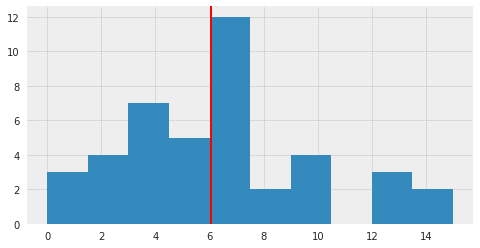

EUROQOL_1
Unique values: 11
p-value: 0.4009412183
Normal: True
Mean: 0.846916756757 std: 0.133864771301


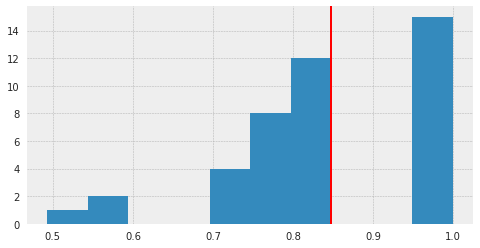

VISUAL_EUROQOL_1
Unique values: 10
p-value: 0.0639696981121
Normal: True
Mean: 70.9459459459 std: 16.7558745149


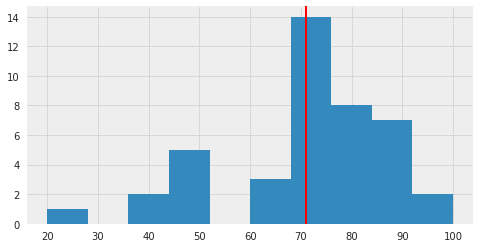

HORAS_USO_MED_NOCHE_3
Unique values: 22
p-value: 0.11216183929
Normal: True
Mean: 5.327 std: 1.82882501962


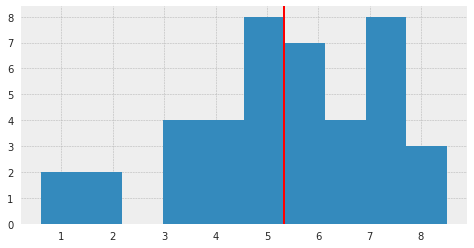

MEDIA TAS_3
Unique values: 33
p-value: 0.700068306867
Normal: True
Mean: 133.881578947 std: 18.3671012212


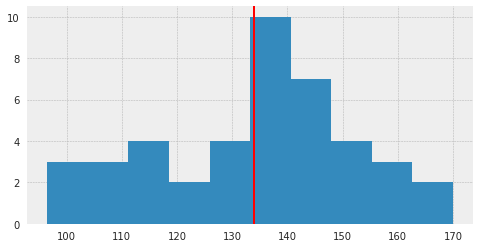

MEDIA TAD_3
Unique values: 31
p-value: 0.027702755921
Normal: False
Mean: 81.2782051282 std: 13.6727518169


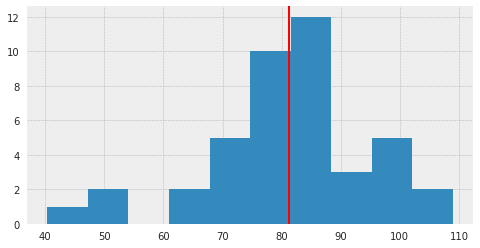

EPWORTH_3
Unique values: 14
p-value: 9.70721968732e-06
Normal: False
Mean: 5.88 std: 3.71837137928


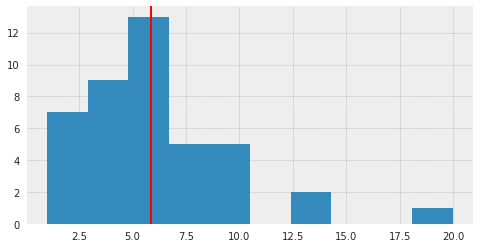

EUROQOL_3
Unique values: 12
p-value: 0.000175912464525
Normal: False
Mean: 0.836695641026 std: 0.190352363586


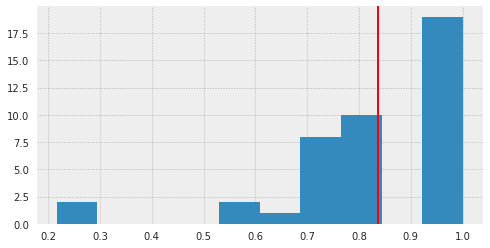

VISUAL EUROQOL_3
Unique values: 11
p-value: 8.54193195793e-06
Normal: False
Mean: 71.6884615385 std: 19.1457674719


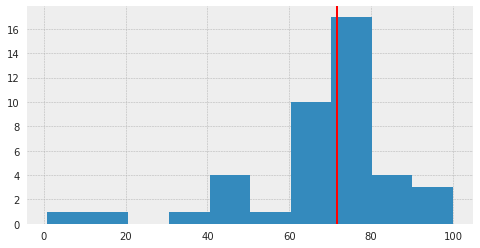

In [209]:
from scipy.stats import boxcox

for i,rv in enumerate(df_all.columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10)
        plt.axvline(np.mean(cleanIc), c="r")
        plt.show()        

#### Distribution categorical features

GENERO
1.0    29
0.0    13
Name: GENERO, dtype: int64


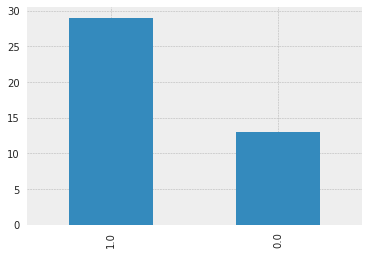

ACTIVO
1.0    25
0.0    17
Name: ACTIVO, dtype: int64


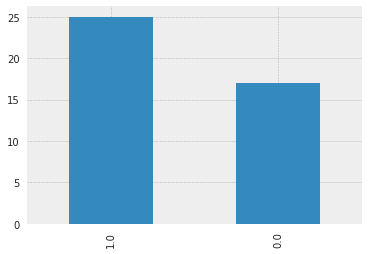

JUBILADO
0.0    28
1.0    14
Name: JUBILADO, dtype: int64


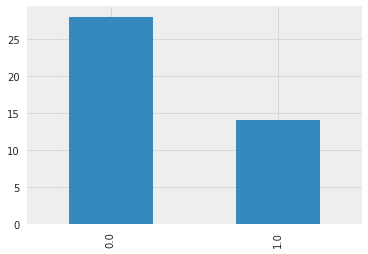

FUMA
0.0    26
1.0    16
Name: FUMA, dtype: int64


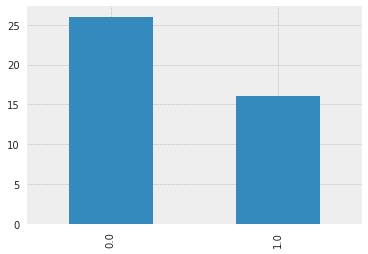

ALCOHOL
0.0    24
1.0    18
Name: ALCOHOL, dtype: int64


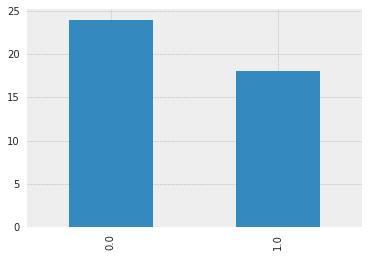

DEPRESION
0.0    35
1.0     7
Name: DEPRESION, dtype: int64


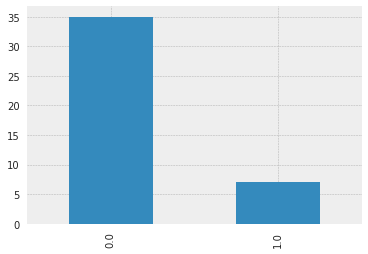

ANSIEDAD
0.0    33
1.0     9
Name: ANSIEDAD, dtype: int64


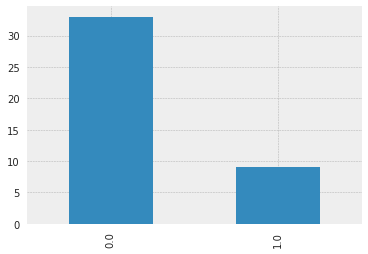

HTA
1.0    25
0.0    17
Name: HTA, dtype: int64


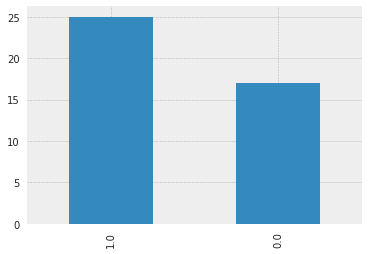

CARDIOPATIA
0.0    30
1.0    12
Name: CARDIOPATIA, dtype: int64


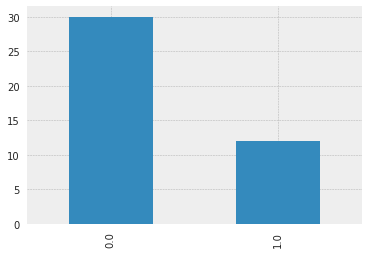

ENF_RESP
0.0    31
1.0    11
Name: ENF_RESP, dtype: int64


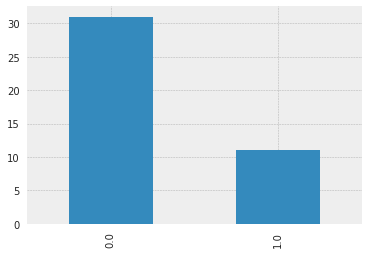

DIABETES
0.0    29
1.0    13
Name: DIABETES, dtype: int64


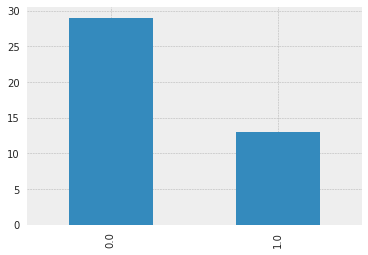

OBESIDAD
1.0    30
0.0    12
Name: OBESIDAD, dtype: int64


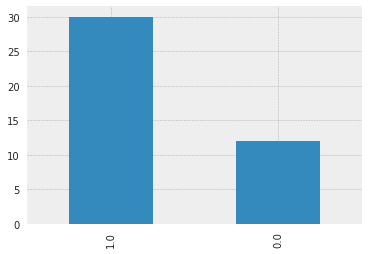

DISLIPEMIA
0.0    26
1.0    16
Name: DISLIPEMIA, dtype: int64


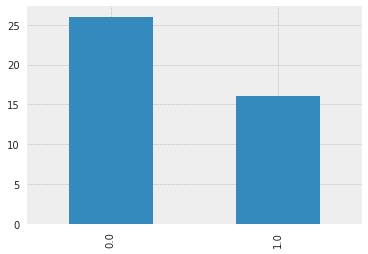

OBSTR_NASAL_CRON
0.0    27
1.0    15
Name: OBSTR_NASAL_CRON, dtype: int64


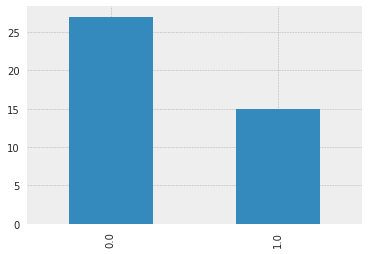

RONCA
3.0    29
2.0    13
Name: RONCA, dtype: int64


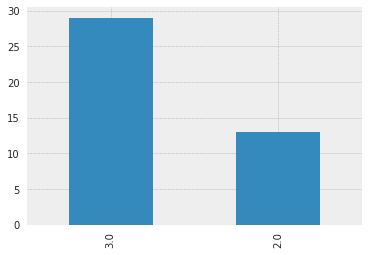

SUE_REP
2.0    19
0.0    11
1.0     7
3.0     5
Name: SUE_REP, dtype: int64


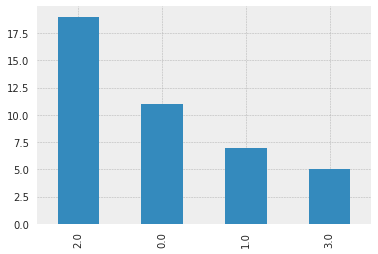

CRISIS_ASF
0.0    24
1.0    14
2.0     4
Name: CRISIS_ASF, dtype: int64


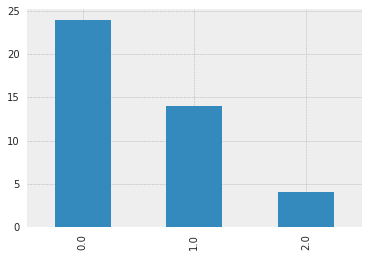

NICTURIA
3.0    16
1.0    12
0.0     9
2.0     5
Name: NICTURIA, dtype: int64


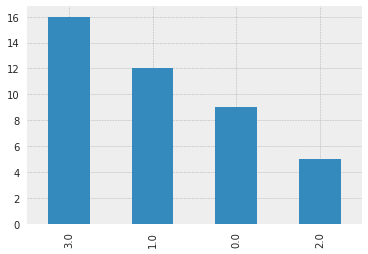

APNEAS_PRES
2.0    13
1.0    10
0.0    10
3.0     9
Name: APNEAS_PRES, dtype: int64


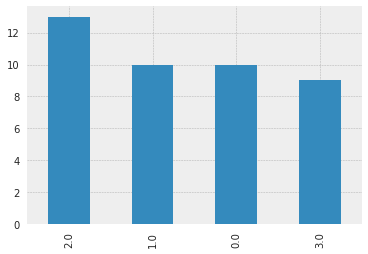

CEFALEA
0.0    29
1.0    13
Name: CEFALEA, dtype: int64


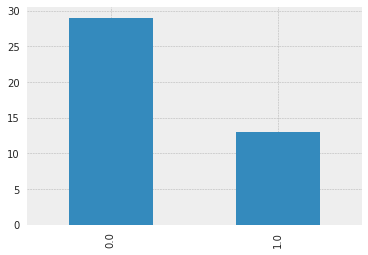

SOMN_DIURN
0.0    13
1.0    11
2.0    10
3.0     8
Name: SOMN_DIURN, dtype: int64


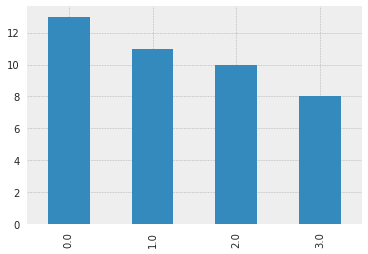

DESPERTAR_NOCT
0.0    21
2.0    11
1.0     5
3.0     5
Name: DESPERTAR_NOCT, dtype: int64


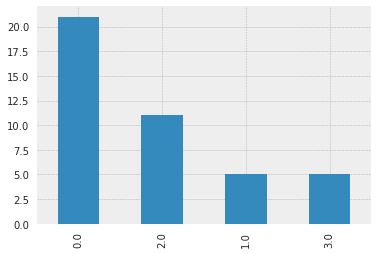

TRAST_CONC
0.0    29
1.0     7
2.0     6
Name: TRAST_CONC, dtype: int64


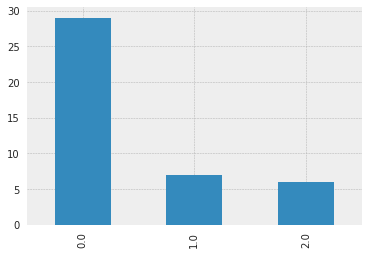

IRR_APAT_DEPR
0.0    23
1.0    13
2.0     6
Name: IRR_APAT_DEPR, dtype: int64


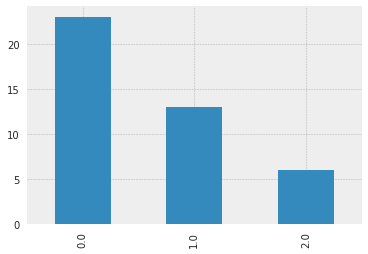

INSOMNIO
0.0    35
1.0     7
Name: INSOMNIO, dtype: int64


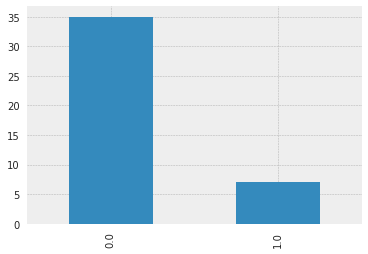

ACT_MOTR_NOCT
0.0    27
1.0    15
Name: ACT_MOTR_NOCT, dtype: int64


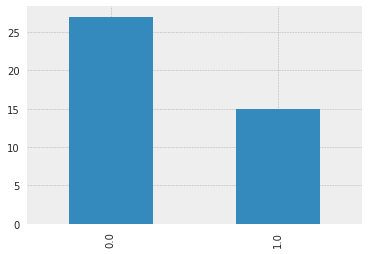

SEN_SUE_REAL_DORM
0.0    33
1.0     9
Name: SEN_SUE_REAL_DORM, dtype: int64


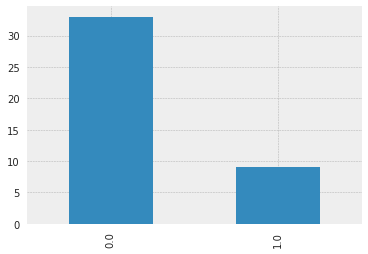

SUE_INT_PIROSIS
0.0    33
1.0     9
Name: SUE_INT_PIROSIS, dtype: int64


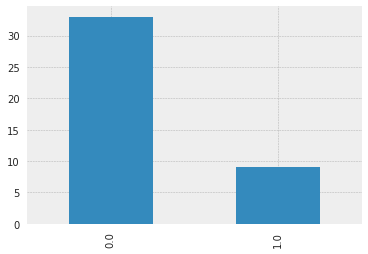

DISM_DESEO_SEX
0.0    25
1.0    17
Name: DISM_DESEO_SEX, dtype: int64


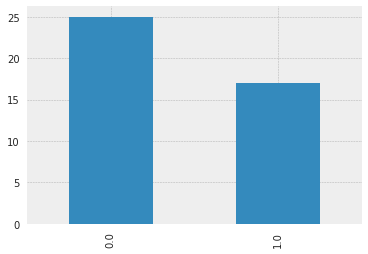

IECAS
0.0    29
1.0    13
Name: IECAS, dtype: int64


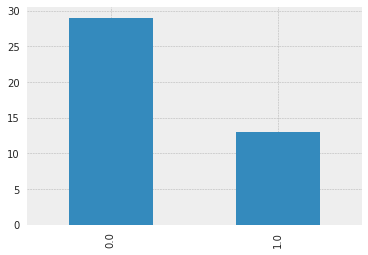

DIURETICOS
0.0    32
1.0    10
Name: DIURETICOS, dtype: int64


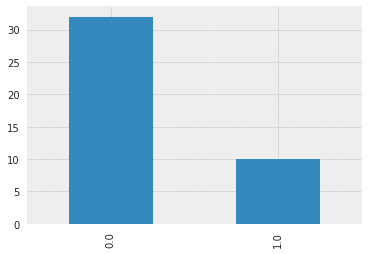

ANTIAGREG
0.0    33
1.0     9
Name: ANTIAGREG, dtype: int64


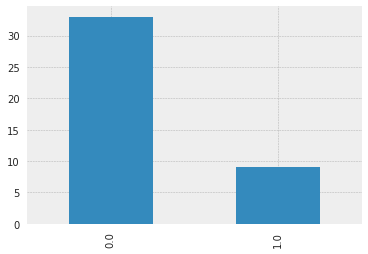

ANTIACID
0.0    32
1.0    10
Name: ANTIACID, dtype: int64


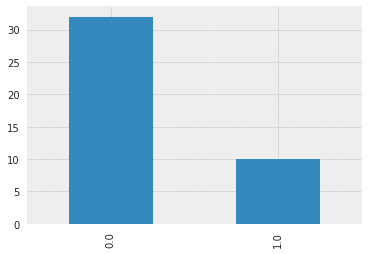

HIPOLIPEM
0.0    27
1.0    15
Name: HIPOLIPEM, dtype: int64


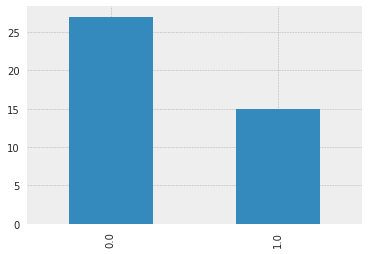

BDZ
0.0    35
1.0     7
Name: BDZ, dtype: int64


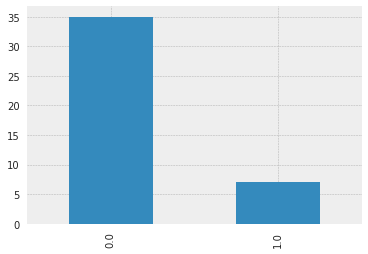

AL_IRR_CUT_MASC_1
0.0    34
1.0     8
Name: AL_IRR_CUT_MASC_1, dtype: int64


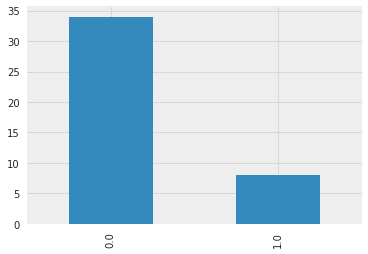

BOCA_SECA_1
0.0    24
1.0    18
Name: BOCA_SECA_1, dtype: int64


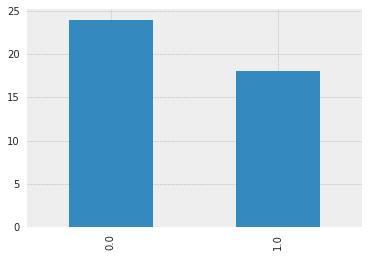

BOCA_SECA_3
0.0    33
1.0     9
Name: BOCA_SECA_3, dtype: int64


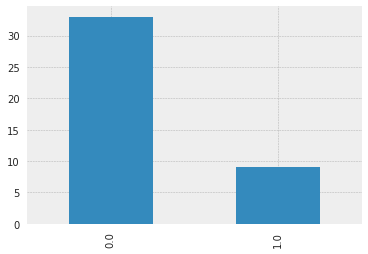

In [210]:
for i,rv in enumerate(columns[:-1]):

    #Compute data
    cleanIc = dfImputed.iloc[:,i]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":
                
        print rv
        print pd.value_counts(cleanIc)                
        pd.value_counts(cleanIc).plot(kind="bar")
        plt.show()


#### Correlated numerical features

In [212]:
#Correlations

relVars = df_all.columns[:-1][catCols==0]
print len(relVars)

dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values
        
        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")
        
        #Pearson corr, classical
        cv1_norm = np.log(cv1 + 1)#preprocessing.normalize(cv1.reshape(-1, 1))
        cv2_norm = np.log(cv2 + 1)#preprocessing.normalize(cv2.reshape(-1, 1))
        c_pr,p_pr = stats.pearsonr(cv1_norm,cv2_norm)
        
        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)

print dfCorr.shape

32
(1024, 8)


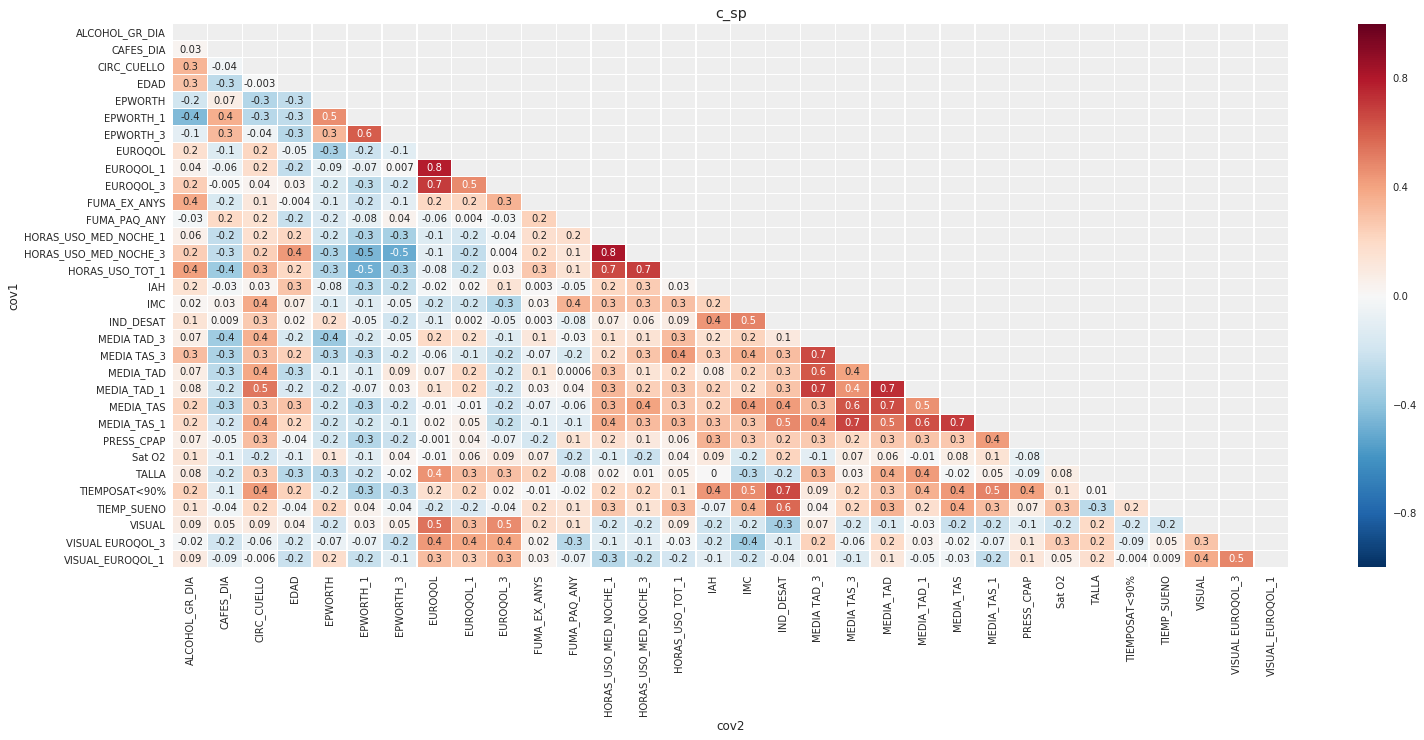

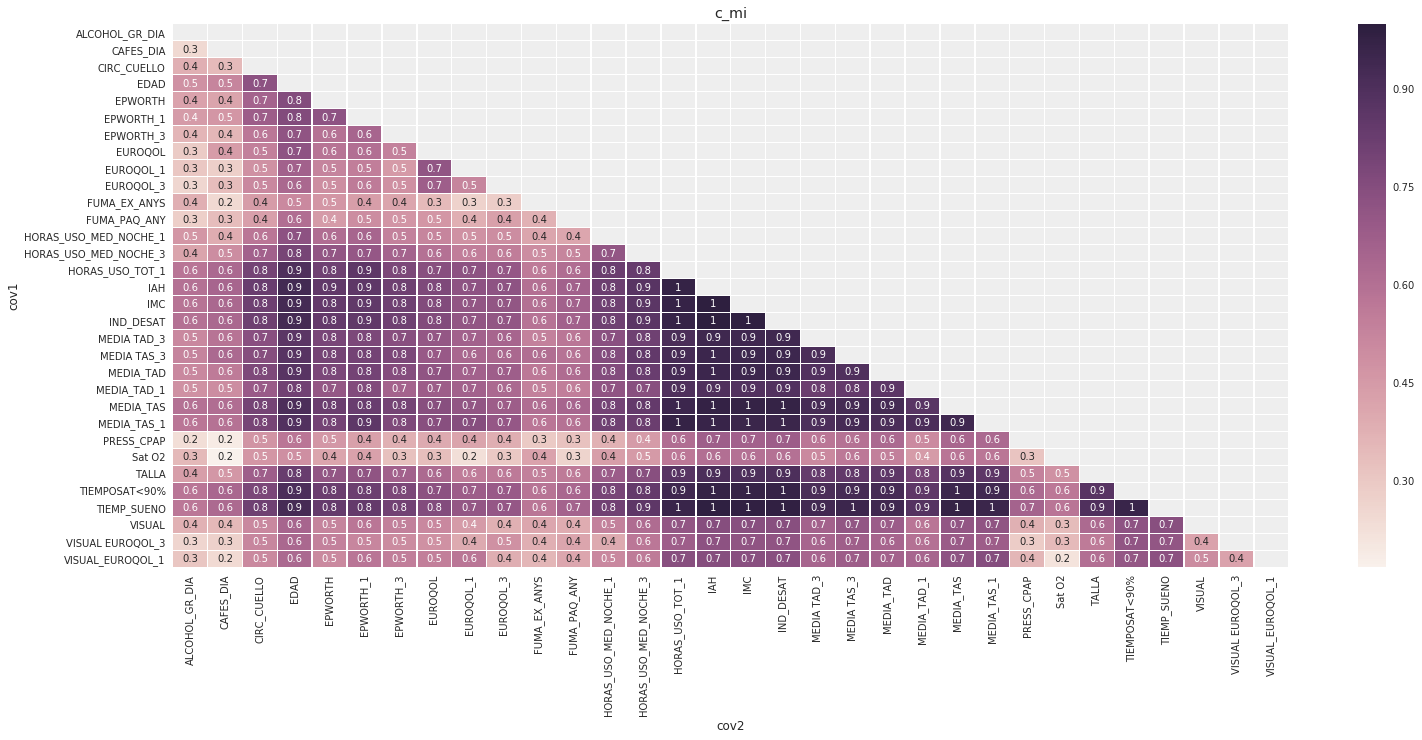

In [213]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,10))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".1g")
    
    plt.title(c)

#### Correlations on categorical features

In [215]:
#Correlations

relVars = df_all.columns[:-1][catCols==1]
print len(relVars)

dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values

        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")

        #Pearson corr, classical
        c_pr,p_pr = stats.pearsonr(cv1,cv2)

        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
print dfCorr.shape

38
(1444, 8)


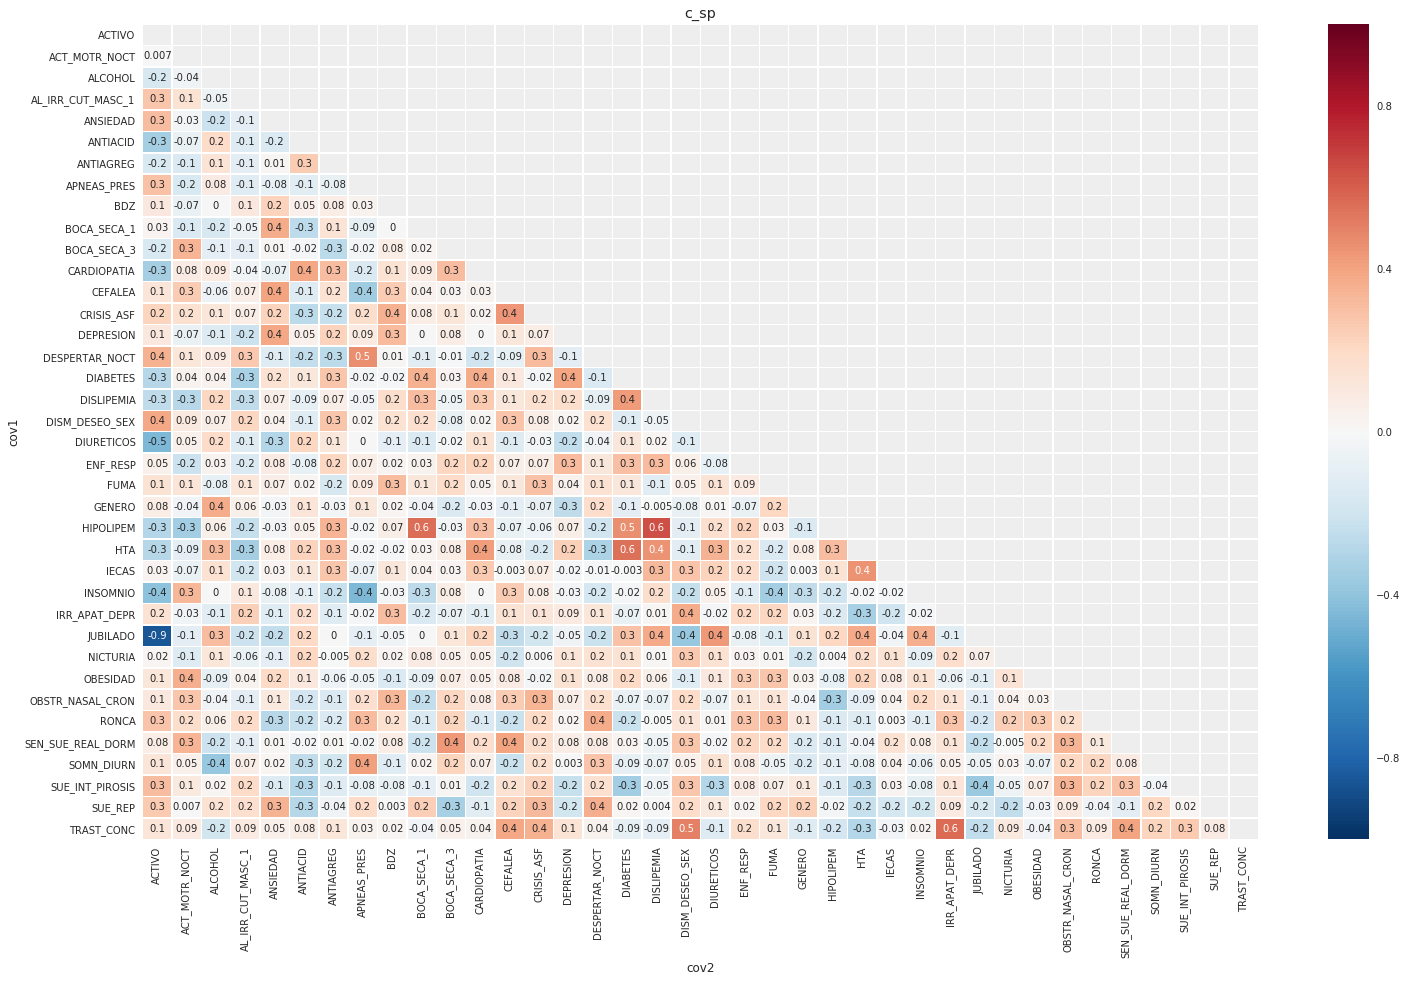

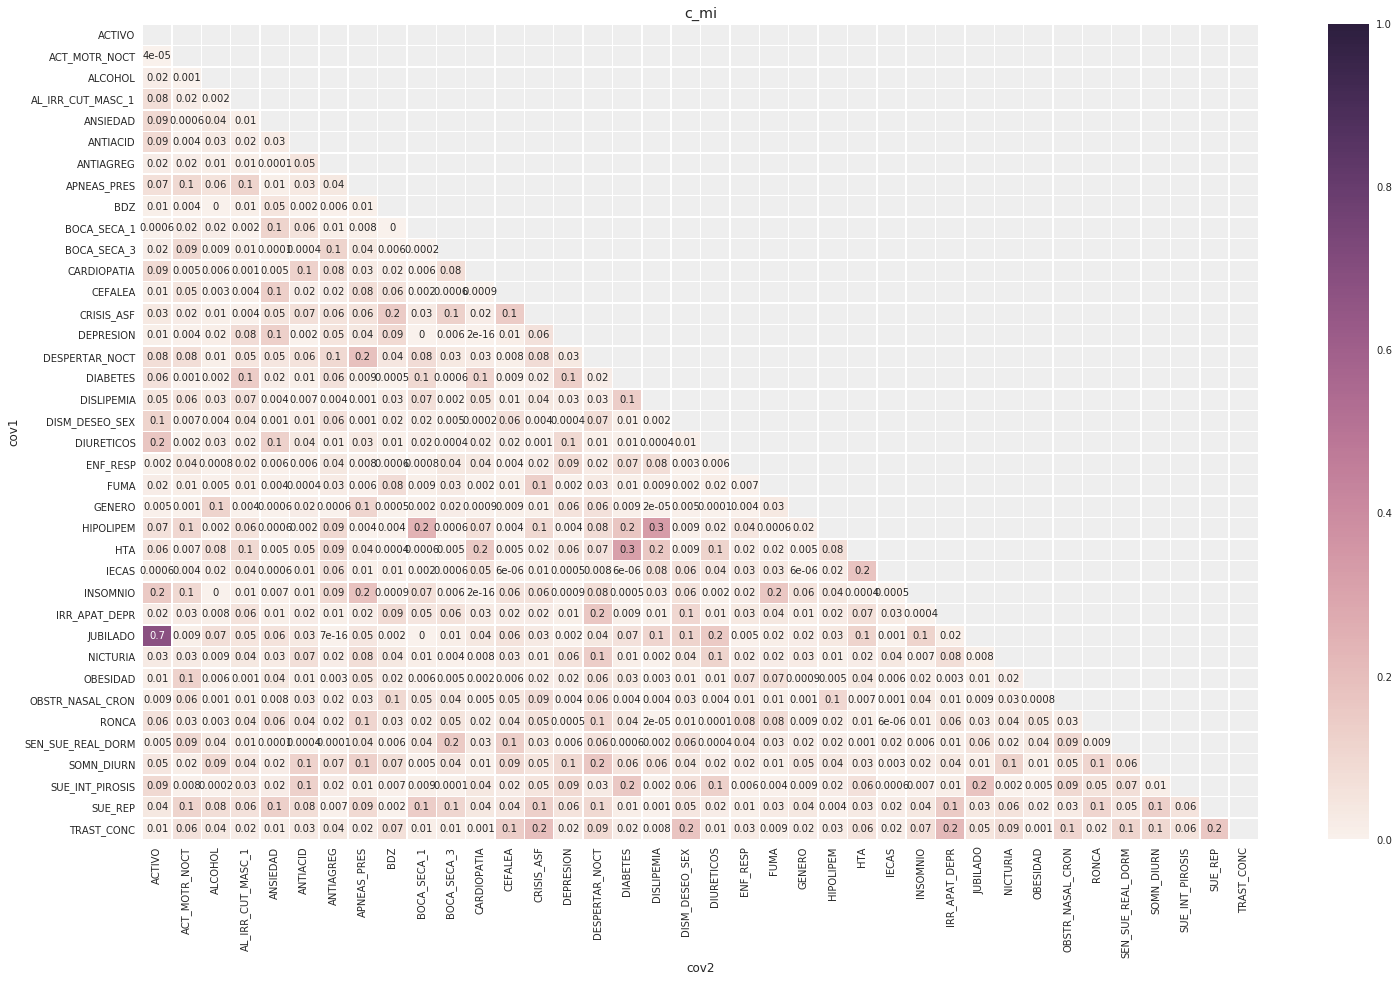

In [216]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,15))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".1g")
    
    plt.title(c)

#### Significance test of features vs class

In [219]:
#dfImputed = pd.DataFrame(dfImputed, columns=reducedCols)
dfImputed["LABEL"] = df_all["LABEL"]

print pd.value_counts(dfImputed["LABEL"])

1.0    24
0.0    18
Name: LABEL, dtype: int64


#### Categorical features vs label (proportions)

In [221]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)

GENERO
   LABEL  GENERO  count      perc
0    0.0     0.0      6  0.333333
1    0.0     1.0     12  0.666667
2    1.0     0.0      7  0.291667
3    1.0     1.0     17  0.708333

0.00232095490716 0.961575746171 ['no']
[ 0.02586207] [ 0.87223763] ['no']


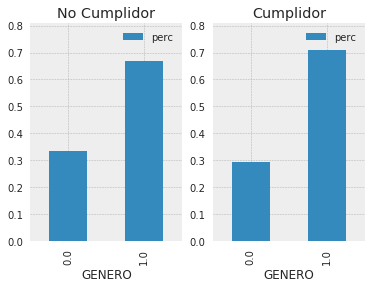

ACTIVO
   LABEL  ACTIVO  count      perc
0    0.0     0.0      8  0.444444
1    0.0     1.0     10  0.555556
2    1.0     0.0      9  0.375000
3    1.0     1.0     15  0.625000

0.0185294117647 0.891724217768 ['no']
[ 0.08333333] [ 0.77282999] ['no']


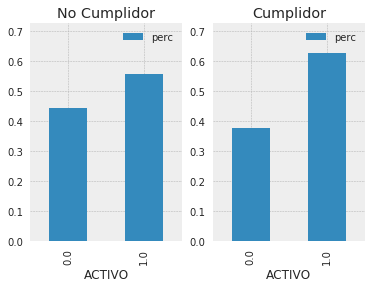

JUBILADO
   LABEL  JUBILADO  count      perc
0    0.0       0.0     12  0.666667
1    0.0       1.0      6  0.333333
2    1.0       0.0     16  0.666667
3    1.0       1.0      8  0.333333

0.0 1.0 ['no']
[ 0.] [ 1.] ['no']


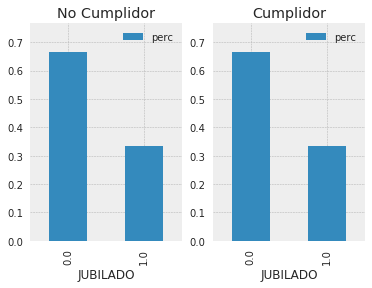

FUMA
   LABEL  FUMA  count      perc
0    0.0   0.0     11  0.611111
1    0.0   1.0      7  0.388889
2    1.0   0.0     15  0.625000
3    1.0   1.0      9  0.375000

0.0525841346154 0.818626187911 ['no']
[ 0.00520833] [ 0.94246759] ['no']


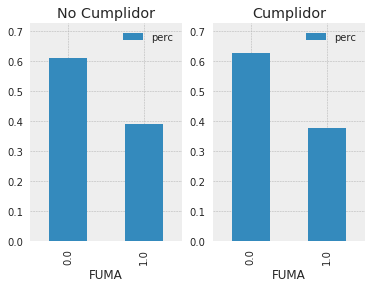

ALCOHOL
   LABEL  ALCOHOL  count      perc
0    0.0      0.0     13  0.722222
1    0.0      1.0      5  0.277778
2    1.0      0.0     11  0.458333
3    1.0      1.0     13  0.541667

1.94646990741 0.162967760232 ['no']
[ 1.6712963] [ 0.196085] ['no']


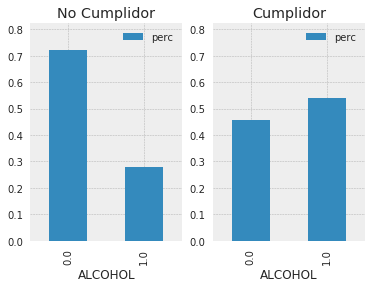

DEPRESION
   LABEL  DEPRESION  count      perc
0    0.0        0.0     16  0.888889
1    0.0        1.0      2  0.111111
2    1.0        0.0     19  0.791667
3    1.0        1.0      5  0.208333

0.175 0.675705848703 ['no']
[ 0.58333333] [ 0.44500872] ['no']


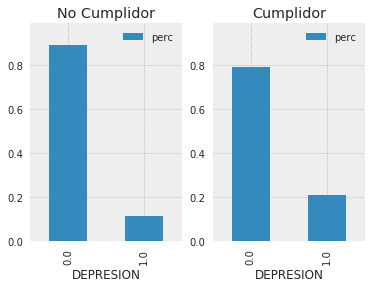

ANSIEDAD
   LABEL  ANSIEDAD  count      perc
0    0.0       0.0     12  0.666667
1    0.0       1.0      6  0.333333
2    1.0       0.0     21  0.875000
3    1.0       1.0      3  0.125000

1.5585016835 0.211884737518 ['no']
[ 2.08333333] [ 0.14891467] ['no']


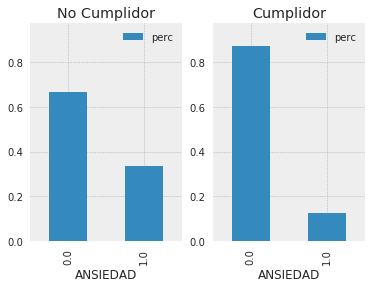

HTA
   LABEL  HTA  count      perc
0    0.0  0.0     12  0.666667
1    0.0  1.0      6  0.333333
2    1.0  0.0      5  0.208333
3    1.0  1.0     19  0.791667

7.16676470588 0.00742665943004 ['yes']
[ 3.63] [ 0.05674682] ['no']


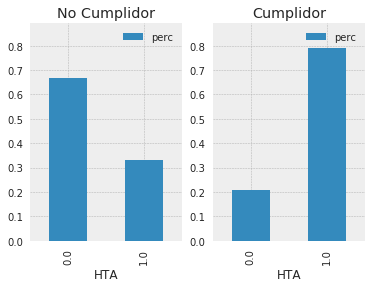

CARDIOPATIA
   LABEL  CARDIOPATIA  count      perc
0    0.0          0.0     13  0.722222
1    0.0          1.0      5  0.277778
2    1.0          0.0     17  0.708333
3    1.0          1.0      7  0.291667

0.0607638888889 0.805292631407 ['no']
[ 0.00694444] [ 0.9335865] ['no']


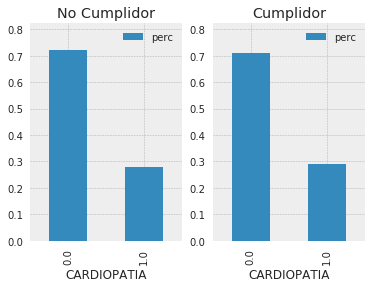

ENF_RESP
   LABEL  ENF_RESP  count      perc
0    0.0       0.0     14  0.777778
1    0.0       1.0      4  0.222222
2    1.0       0.0     17  0.708333
3    1.0       1.0      7  0.291667

0.0230938416422 0.879213294222 ['no']
[ 0.18939394] [ 0.66342152] ['no']


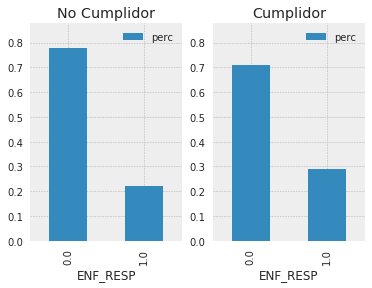

DIABETES
   LABEL  DIABETES  count      perc
0    0.0       0.0     13  0.722222
1    0.0       1.0      5  0.277778
2    1.0       0.0     16  0.666667
3    1.0       1.0      8  0.333333

0.00232095490716 0.961575746171 ['no']
[ 0.1025641] [ 0.74877404] ['no']


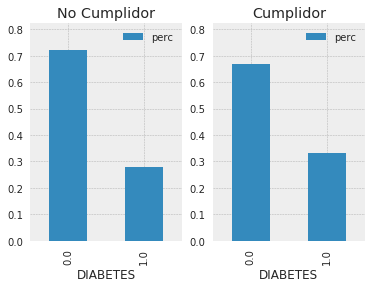

OBESIDAD
   LABEL  OBESIDAD  count      perc
0    0.0       0.0      7  0.388889
1    0.0       1.0     11  0.611111
2    1.0       0.0      5  0.208333
3    1.0       1.0     19  0.791667

0.877430555556 0.348906396538 ['no']
[ 0.46944444] [ 0.49324286] ['no']


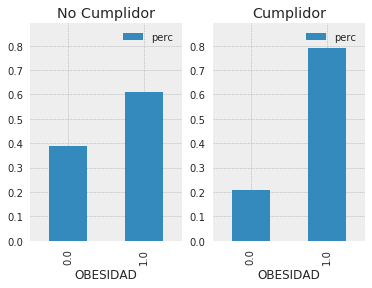

DISLIPEMIA
   LABEL  DISLIPEMIA  count      perc
0    0.0         0.0     10  0.555556
1    0.0         1.0      8  0.444444
2    1.0         0.0     16  0.666667
3    1.0         1.0      8  0.333333

0.170372596154 0.679780881804 ['no']
[ 0.33333333] [ 0.56370286] ['no']


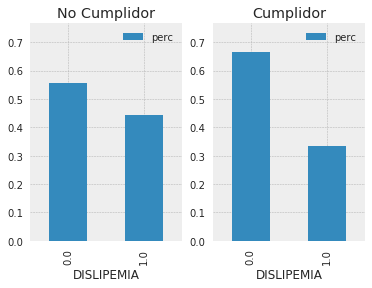

OBSTR_NASAL_CRON
   LABEL  OBSTR_NASAL_CRON  count      perc
0    0.0               0.0     10  0.555556
1    0.0               1.0      8  0.444444
2    1.0               0.0     17  0.708333
3    1.0               1.0      7  0.291667

0.486111111111 0.485667196335 ['no']
[ 0.67222222] [ 0.41227791] ['no']


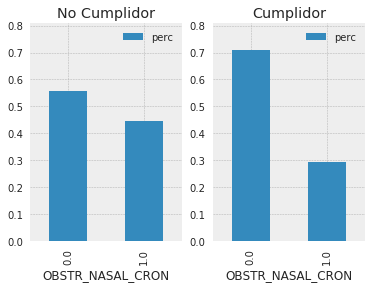

RONCA
   LABEL  RONCA  count      perc
0    0.0    2.0      7  0.388889
1    0.0    3.0     11  0.611111
2    1.0    2.0      6  0.250000
3    1.0    3.0     18  0.750000

0.39224137931 0.531123584471 ['no']
[ 0.07374631] [ 0.78595827] ['no']


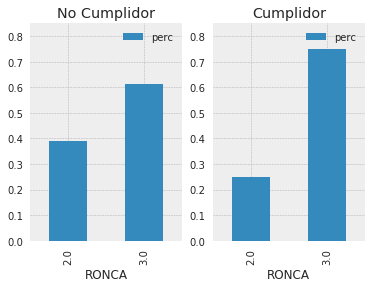

SUE_REP
   LABEL  SUE_REP  count      perc
0    0.0      0.0      4  0.222222
1    0.0      1.0      2  0.111111
2    0.0      2.0      8  0.444444
3    0.0      3.0      4  0.222222
4    1.0      0.0      7  0.291667
5    1.0      1.0      5  0.208333
6    1.0      2.0     11  0.458333
7    1.0      3.0      1  0.041667

3.59377990431 0.30880131253 ['no']
[ 1.25] [ 0.26355248] ['no']


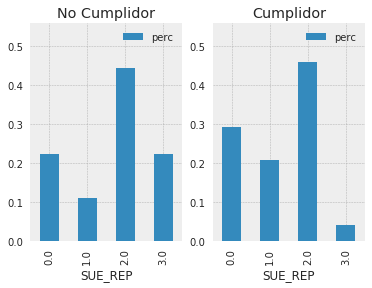

CRISIS_ASF
   LABEL  CRISIS_ASF  count      perc
0    0.0         0.0      7  0.388889
1    0.0         1.0      9  0.500000
2    0.0         2.0      2  0.111111
3    1.0         0.0     17  0.708333
4    1.0         1.0      5  0.208333
5    1.0         2.0      2  0.083333

4.54513888889 0.10304706592 ['no']
[ 2.36742424] [ 0.12389132] ['no']


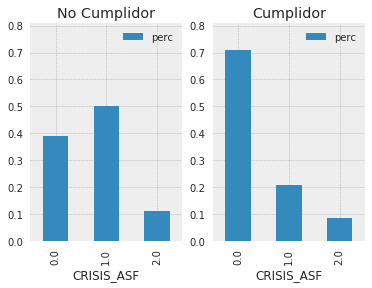

NICTURIA
   LABEL  NICTURIA  count      perc
0    0.0       0.0      4  0.222222
1    0.0       1.0      6  0.333333
2    0.0       2.0      2  0.111111
3    0.0       3.0      6  0.333333
4    1.0       0.0      5  0.208333
5    1.0       1.0      6  0.250000
6    1.0       2.0      3  0.125000
7    1.0       3.0     10  0.416667

0.463425925926 0.926849885018 ['no']
[ 0.23333333] [ 0.62906315] ['no']


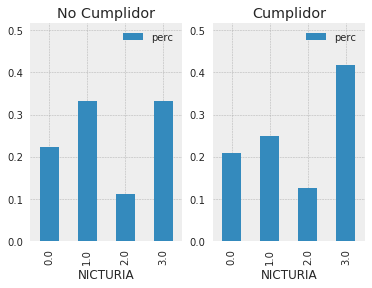

APNEAS_PRES
   LABEL  APNEAS_PRES  count      perc
0    0.0          0.0      5  0.277778
1    0.0          1.0      5  0.277778
2    0.0          2.0      5  0.277778
3    0.0          3.0      3  0.166667
4    1.0          0.0      5  0.208333
5    1.0          1.0      5  0.208333
6    1.0          2.0      8  0.333333
7    1.0          3.0      6  0.250000

0.852564102564 0.836857397683 ['no']
[ 0.58333333] [ 0.44500872] ['no']


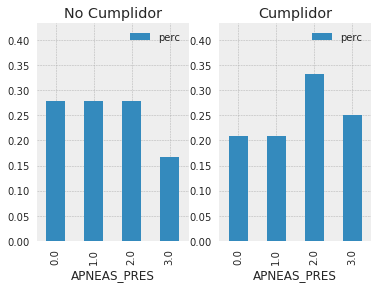

CEFALEA
   LABEL  CEFALEA  count      perc
0    0.0      0.0      8  0.444444
1    0.0      1.0     10  0.555556
2    1.0      0.0     21  0.875000
3    1.0      1.0      3  0.125000

7.02088859416 0.00805642398957 ['yes']
[ 6.16025641] [ 0.01306523] ['yes']


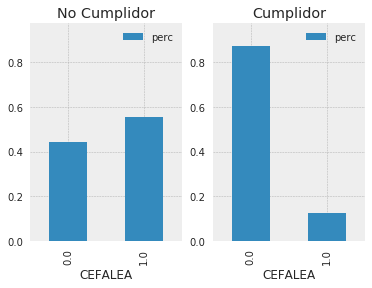

SOMN_DIURN
   LABEL  SOMN_DIURN  count      perc
0    0.0         0.0      4  0.222222
1    0.0         1.0      7  0.388889
2    0.0         2.0      4  0.222222
3    0.0         3.0      3  0.166667
4    1.0         0.0      9  0.375000
5    1.0         1.0      4  0.166667
6    1.0         2.0      6  0.250000
7    1.0         3.0      5  0.208333

2.84211829837 0.416613345013 ['no']
[ 0.01363636] [ 0.90703848] ['no']


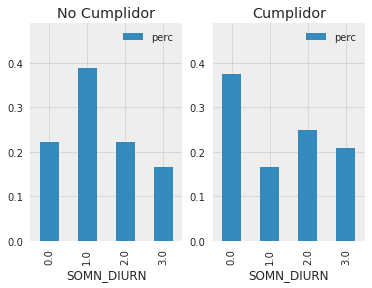

DESPERTAR_NOCT
   LABEL  DESPERTAR_NOCT  count      perc
0    0.0             0.0      9  0.500000
1    0.0             1.0      3  0.166667
2    0.0             2.0      4  0.222222
3    0.0             3.0      2  0.111111
4    1.0             0.0     12  0.500000
5    1.0             1.0      2  0.083333
6    1.0             2.0      7  0.291667
7    1.0             3.0      3  0.125000

0.806060606061 0.848016873903 ['no']
[ 0.09722222] [ 0.75518889] ['no']


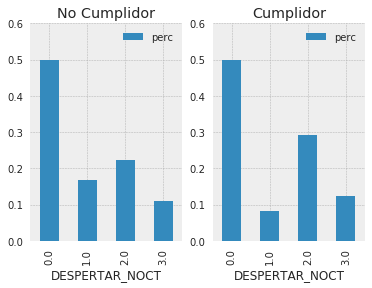

TRAST_CONC
   LABEL  TRAST_CONC  count      perc
0    0.0         0.0     10  0.555556
1    0.0         1.0      2  0.111111
2    0.0         2.0      6  0.333333
3    1.0         0.0     19  0.791667
4    1.0         1.0      5  0.208333

9.41379310345 0.00903276685306 ['yes']
[ 7.37280702] [ 0.00662175] ['yes']


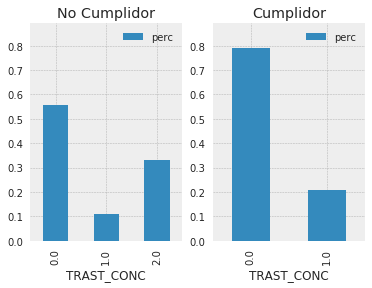

IRR_APAT_DEPR
   LABEL  IRR_APAT_DEPR  count      perc
0    0.0            0.0      7  0.388889
1    0.0            1.0      6  0.333333
2    0.0            2.0      5  0.277778
3    1.0            0.0     16  0.666667
4    1.0            1.0      7  0.291667
5    1.0            2.0      1  0.041667

5.5208565589 0.0632646675997 ['no']
[ 4.56333333] [ 0.03266344] ['yes']


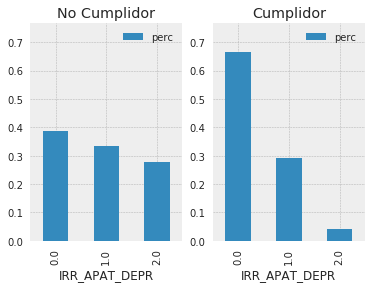

INSOMNIO
   LABEL  INSOMNIO  count      perc
0    0.0       0.0     13  0.722222
1    0.0       1.0      5  0.277778
2    1.0       0.0     22  0.916667
3    1.0       1.0      2  0.083333

1.575 0.209482375716 ['no']
[ 2.33333333] [ 0.12663046] ['no']


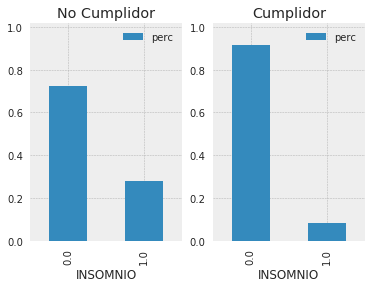

ACT_MOTR_NOCT
   LABEL  ACT_MOTR_NOCT  count      perc
0    0.0            0.0     11  0.611111
1    0.0            1.0      7  0.388889
2    1.0            0.0     16  0.666667
3    1.0            1.0      8  0.333333

0.00216049382716 0.962926787787 ['no']
[ 0.08888889] [ 0.76559448] ['no']


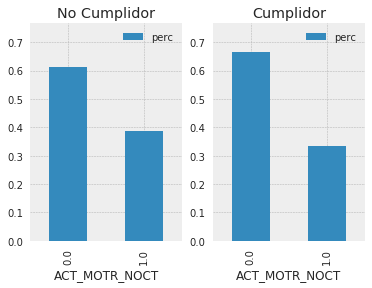

SEN_SUE_REAL_DORM
   LABEL  SEN_SUE_REAL_DORM  count      perc
0    0.0                0.0     14  0.777778
1    0.0                1.0      4  0.222222
2    1.0                0.0     19  0.791667
3    1.0                1.0      5  0.208333

0.0736531986532 0.786090147989 ['no']
[ 0.00925926] [ 0.92334184] ['no']


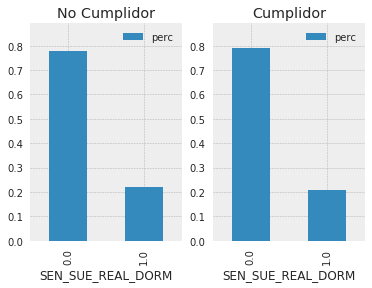

SUE_INT_PIROSIS
   LABEL  SUE_INT_PIROSIS  count      perc
0    0.0              0.0     15  0.833333
1    0.0              1.0      3  0.166667
2    1.0              0.0     18  0.750000
3    1.0              1.0      6  0.250000

0.0736531986532 0.786090147989 ['no']
[ 0.33333333] [ 0.56370286] ['no']


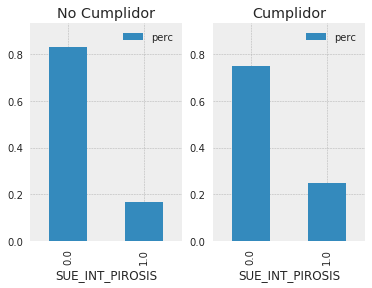

DISM_DESEO_SEX
   LABEL  DISM_DESEO_SEX  count      perc
0    0.0             0.0     10  0.555556
1    0.0             1.0      8  0.444444
2    1.0             0.0     15  0.625000
3    1.0             1.0      9  0.375000

0.0185294117647 0.891724217768 ['no']
[ 0.12254902] [ 0.72628615] ['no']


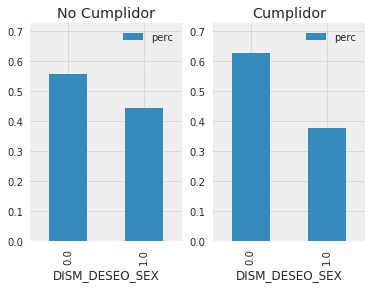

IECAS
   LABEL  IECAS  count      perc
0    0.0    0.0     15  0.833333
1    0.0    1.0      3  0.166667
2    1.0    0.0     14  0.583333
3    1.0    1.0     10  0.416667

1.95192307692 0.162379771516 ['no']
[ 2.07692308] [ 0.14954135] ['no']


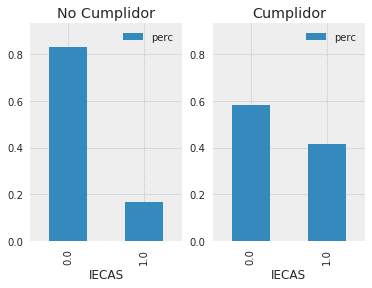

DIURETICOS
   LABEL  DIURETICOS  count      perc
0    0.0         0.0     16  0.888889
1    0.0         1.0      2  0.111111
2    1.0         0.0     16  0.666667
3    1.0         1.0      8  0.333333

1.708984375 0.191117195685 ['no']
[ 2.13333333] [ 0.14412703] ['no']


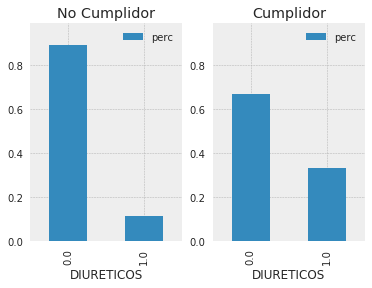

ANTIAGREG
   LABEL  ANTIAGREG  count      perc
0    0.0        0.0     16  0.888889
1    0.0        1.0      2  0.111111
2    1.0        0.0     17  0.708333
3    1.0        1.0      7  0.291667

1.06355218855 0.302406409109 ['no']
[ 1.56481481] [ 0.21096163] ['no']


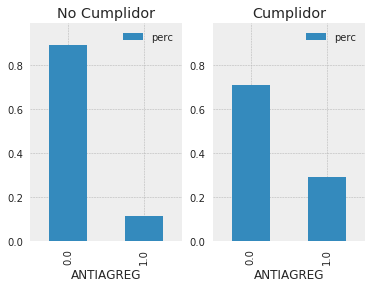

ANTIACID
   LABEL  ANTIACID  count      perc
0    0.0       0.0     14  0.777778
1    0.0       1.0      4  0.222222
2    1.0       0.0     18  0.750000
3    1.0       1.0      6  0.250000

0.024609375 0.875344344228 ['no']
[ 0.03333333] [ 0.85513214] ['no']


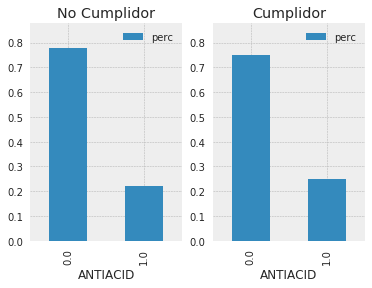

HIPOLIPEM
   LABEL  HIPOLIPEM  count      perc
0    0.0        0.0     11  0.611111
1    0.0        1.0      7  0.388889
2    1.0        0.0     16  0.666667
3    1.0        1.0      8  0.333333

0.00216049382716 0.962926787787 ['no']
[ 0.08888889] [ 0.76559448] ['no']


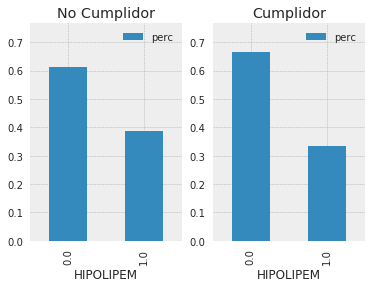

BDZ
   LABEL  BDZ  count      perc
0    0.0  0.0     13  0.722222
1    0.0  1.0      5  0.277778
2    1.0  0.0     22  0.916667
3    1.0  1.0      2  0.083333

1.575 0.209482375716 ['no']
[ 2.33333333] [ 0.12663046] ['no']


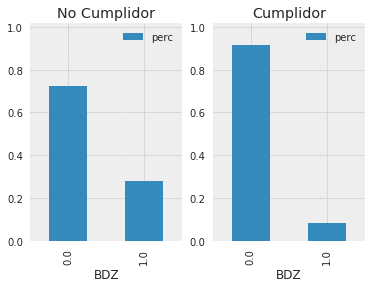

AL_IRR_CUT_MASC_1
   LABEL  AL_IRR_CUT_MASC_1  count      perc
0    0.0                0.0     14  0.777778
1    0.0                1.0      4  0.222222
2    1.0                0.0     20  0.833333
3    1.0                1.0      4  0.166667

0.00321691176471 0.954769973929 ['no']
[ 0.16666667] [ 0.6830914] ['no']


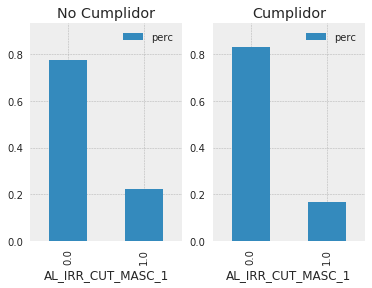

BOCA_SECA_1
   LABEL  BOCA_SECA_1  count      perc
0    0.0          0.0      7  0.388889
1    0.0          1.0     11  0.611111
2    1.0          0.0     17  0.708333
3    1.0          1.0      7  0.291667

3.08072916667 0.0792250003265 ['no']
[ 2.44907407] [ 0.11759422] ['no']


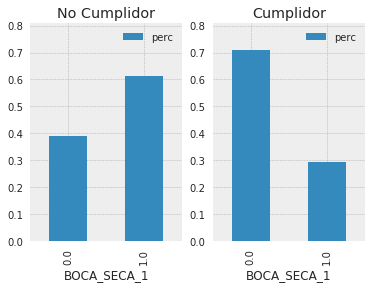

BOCA_SECA_3
   LABEL  BOCA_SECA_3  count      perc
0    0.0          0.0     14  0.777778
1    0.0          1.0      4  0.222222
2    1.0          0.0     19  0.791667
3    1.0          1.0      5  0.208333

0.0736531986532 0.786090147989 ['no']
[ 0.00925926] [ 0.92334184] ['no']


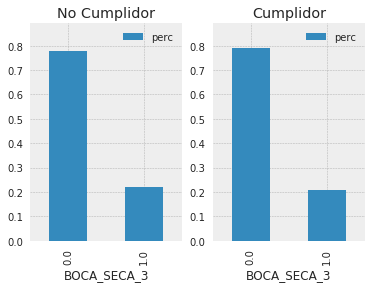

In [222]:
from scipy.stats import chisquare

mat = []
sigArr = []
for i in range(len(catCols)):
    if catCols[i] == 1:
                
        data = dfImputed.groupby(["LABEL",dfImputed.columns[i]]).count().iloc[:,:1].reset_index()
        data["count"] = data.iloc[:,2]
        data["perc"] = 0.0
        for j in range(data.shape[0]):
            if data["LABEL"].iloc[j] == 0:
                data.set_value(j,"perc", data.iloc[j]["count"]/float(data[data["LABEL"] == 0]["count"].sum()))
            else:
                data.set_value(j,"perc", data.iloc[j]["count"]/float(data[data["LABEL"] == 1]["count"].sum()))

        
        #Significance tests
        r1, p1 = chi2(dfImputed.iloc[:,i].values.astype(int).reshape(-1,1),dfImputed["LABEL"].values.astype(int).reshape(-1,1))        
        r,p,df,kounts = chi_square_of_df_cols(dfImputed, dfImputed.columns[i], 'LABEL')
        
        #Save results
        feat = dfImputed.columns[i]
        vals = dfImputed[dfImputed.columns[i]].sort_values().unique()
        
        sigArr.append([feat, vals, "-","-", 
                       r,p,
                       "yes" if p < 0.05 else "no", 
                       "yes" if p < 0.01 else "no",
                       "yes" if p < 0.001 else "no",
                       "cat"])
        
        konts = data.loc[:,"count"].tolist()
        konts_0 = np.sum(dfImputed["LABEL"] == 0)
        konts_1 = np.sum(dfImputed["LABEL"] == 1)        
        for v in vals:
            feat_new = feat + "__" + str(int(v))
            
            val = data[np.logical_and(data["LABEL"]==0.0, data[feat] == v)]["count"]
            if val.shape[0] > 0:
                val_0 = val.iloc[0]
                perc_0 = round(val_0 / float(konts_0), 2)
            else:
                val_0 = 0
                perc_0 = 0.0

            val = data[np.logical_and(data["LABEL"]==1.0, data[feat] == v)]["count"]
            if val.shape[0] > 0:                
                val_1 = val.iloc[0]            
                perc_1 = round(val_1 / float(konts_1), 2)
            else:
                val_1 = 0
                perc_1 = 0.0
            
            sigArr.append([feat_new, v, str(val_0) + " (" + str(perc_0) +"%)", str(val_1) + "(" + str(perc_1) + "%)", "", "", "", "","", "cat"])
        
        #Print results              
        print dfImputed.columns[i]        
        print data.loc[:,["LABEL", dfImputed.columns[i], "count","perc"]]
        print
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]

        ax = plt.subplot(1,2,1)
        data[data.LABEL == 0].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")
        ax.set_ylim(0,np.nanmax(data["perc"].values +.1))
        ax.set_title("No Cumplidor")
        ax = plt.subplot(1,2,2)
        data[data.LABEL == 1].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")
        ax.set_ylim(0,np.nanmax(data["perc"].values +.1))
        ax.set_title("Cumplidor")
        plt.show()
        
dfDescCat = pd.DataFrame(sigArr, columns=["feature","values","non_compliant","compliant","r","p_value","p<0.05","p<0.01","p<0.001","type"])

In [223]:
print "Total Categoric features:", np.sum(catCols == 1)
print "Statistically significant:", dfDescCat[dfDescCat["p_value"] < 0.05].shape[0]

pd.set_option('display.max_rows', 500)
sigFeats = dfDescCat[dfDescCat["p_value"]<0.05]["feature"].values
"""
sigFeats = np.insert(sigFeats,-1,"BOCA_SECA_1")
sigFeats = np.insert(sigFeats,-1,"ANTIACID")
sigFeats = np.insert(sigFeats,-1,"RONCA")
sigFeats = np.insert(sigFeats,-1,"SUE_INT_PIROSIS")
sigFeats = np.insert(sigFeats,-1,"IRR_APAT_DEPR")
"""
print sigFeats

ix = []
for f in sigFeats:
    ix.extend(dfDescCat.loc[dfDescCat["feature"].str.contains(f)].index.values)
    
print ix
dfDescCat.ix[ix].iloc[:,:-1]

Total Categoric features: 38
Statistically significant: 3
['HTA' 'CEFALEA' 'TRAST_CONC']
[21, 22, 23, 64, 65, 66, 77, 78, 79, 80]


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


,feature,values,non_compliant,compliant,r,p_value,p<0.05,p<0.01,p<0.001
21,HTA,"[0.0, 1.0]",-,-,7.16676,0.00742666,yes,yes,no
22,HTA__0,0,12 (0.67%),5(0.21%),,,,,
23,HTA__1,1,6 (0.33%),19(0.79%),,,,,
64,CEFALEA,"[0.0, 1.0]",-,-,7.02089,0.00805642,yes,yes,no
65,CEFALEA__0,0,8 (0.44%),21(0.88%),,,,,
66,CEFALEA__1,1,10 (0.56%),3(0.13%),,,,,
77,TRAST_CONC,"[0.0, 1.0, 2.0]",-,-,9.41379,0.00903277,yes,yes,no
78,TRAST_CONC__0,0,10 (0.56%),19(0.79%),,,,,
79,TRAST_CONC__1,1,2 (0.11%),5(0.21%),,,,,
80,TRAST_CONC__2,2,6 (0.33%),0(0.0%),,,,,


#### Numerical data

EDAD
   LABEL       mean        std  count
0    0.0  51.666667  12.058680   18.0
1    1.0  60.875000  11.685415   24.0
[ 1668.03291044] [ 0.] ['yes']
[ 40.84155862] [ 0.] ['yes']
0.0 5.25680893096e-16 ['yes']


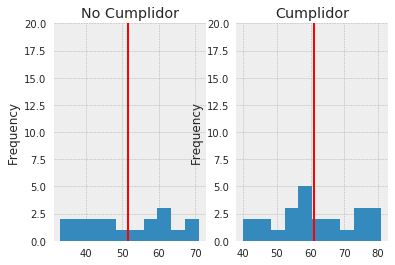

FUMA_PAQ_ANY
   LABEL        mean         std  count
0    0.0  146.833333  217.397237   18.0
1    1.0  156.833333  281.105220   24.0
[ 16.22143415] [ 0.00012519] ['yes']
[ 4.02758416] [ 0.00012519] ['yes']
759.0 0.118668318245 ['no']


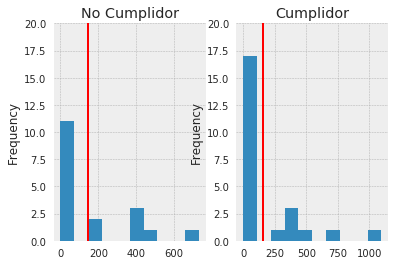

FUMA_EX_ANYS
   LABEL      mean       std  count
0    0.0  0.666667  1.909727   18.0
1    1.0  4.218750  6.807649   24.0
[ 0.02165222] [ 0.88337723] ['no']
[ 0.14714694] [ 0.88337723] ['no']
759.0 0.109556573689 ['no']


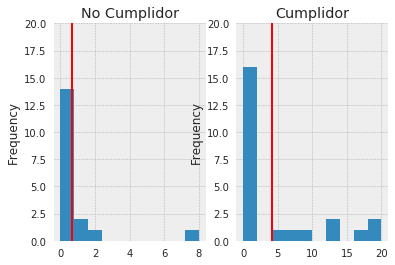

ALCOHOL_GR_DIA
   LABEL      mean       std  count
0    0.0  3.611111  9.671905   18.0
1    1.0  4.898333  9.091701   24.0
[ 1.09849164] [ 0.29767679] ['no']
[ 1.04808952] [ 0.29767679] ['no']
822.0 0.27947537567 ['no']


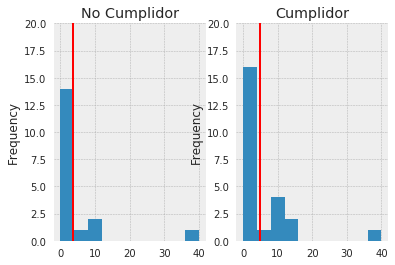

CAFES_DIA
   LABEL      mean       std  count
0    0.0  1.722222  1.363626   18.0
1    1.0  1.083333  1.203859   24.0
[ 1.27446578] [ 0.26222249] ['no']
[ 1.1289224] [ 0.26222249] ['no']
582.0 0.00221482667712 ['yes']


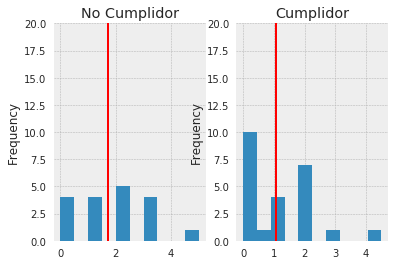

TIEMP_SUENO
   LABEL        mean        std  count
0    0.0  382.097561  73.058392   18.0
1    1.0  395.500000  75.001449   24.0
[ 4081.36677073] [ 0.] ['yes']
[ 63.88557561] [ 0.] ['yes']
0.0 5.29287858451e-16 ['yes']


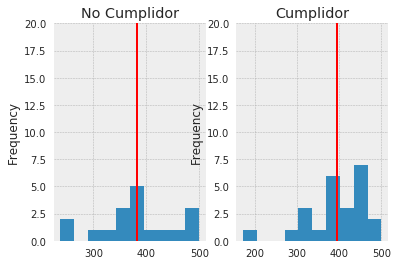

IAH
   LABEL       mean        std  count
0    0.0  48.500000  19.763333   18.0
1    1.0  56.604583  21.582131   24.0
[ 1095.71218452] [ 0.] ['yes']
[ 33.10154354] [ 0.] ['yes']
0.0 5.29649830571e-16 ['yes']


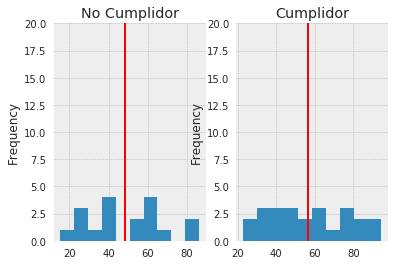

TIEMPOSAT<90%
   LABEL       mean        std  count
0    0.0  54.576667  77.477124   18.0
1    1.0  73.347917  74.752542   24.0
[ 196.05699183] [ 0.] ['yes']
[ 14.00203527] [ 0.] ['yes']
24.0 3.04845862357e-15 ['yes']


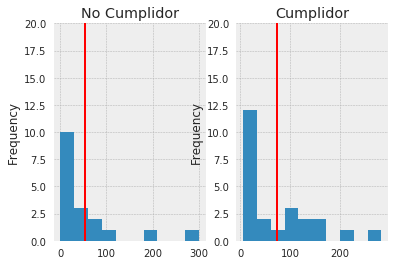

IND_DESAT
   LABEL       mean        std  count
0    0.0  35.517222  22.627261   18.0
1    1.0  42.180833  27.438034   24.0
[ 324.69263443] [ 0.] ['yes']
[ 18.01922957] [ 0.] ['yes']
0.0 5.29468815459e-16 ['yes']


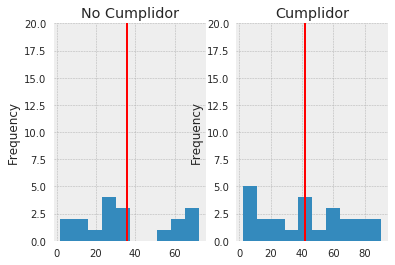

TALLA
   LABEL      mean       std  count
0    0.0  1.658333  0.103427   18.0
1    1.0  1.675833  0.097040   24.0
[ 27.90327745] [ 0.00000103] ['yes']
[ 5.28235529] [ 0.00000103] ['yes']
0.0 5.24423918593e-16 ['yes']


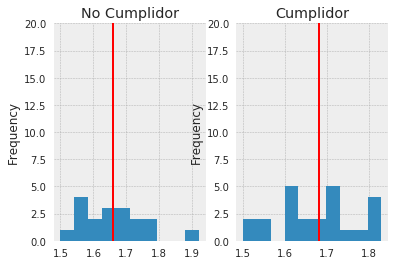

IMC
   LABEL       mean       std  count
0    0.0  32.858333  7.515792   18.0
1    1.0  34.566250  5.604268   24.0
[ 1297.0339548] [ 0.] ['yes']
[ 36.01435762] [ 0.] ['yes']
0.0 5.29468815459e-16 ['yes']


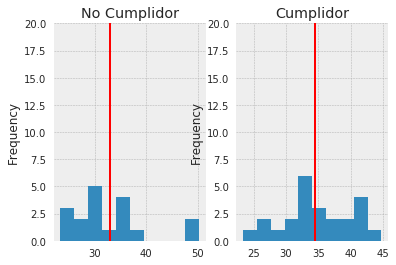

CIRC_CUELLO
   LABEL       mean       std  count
0    0.0  42.611111  5.112141   18.0
1    1.0  42.458333  3.694640   24.0
[ 1647.60587058] [ 0.] ['yes']
[ 40.59071163] [ 0.] ['yes']
0.0 5.09733368214e-16 ['yes']


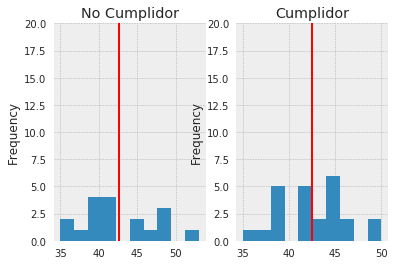

MEDIA_TAS
   LABEL        mean        std  count
0    0.0  127.833333  16.522712   18.0
1    1.0  144.937500  20.623600   24.0
[ 2907.49852077] [ 0.] ['yes']
[ 53.92122514] [ 0.] ['yes']
0.0 5.28564611095e-16 ['yes']


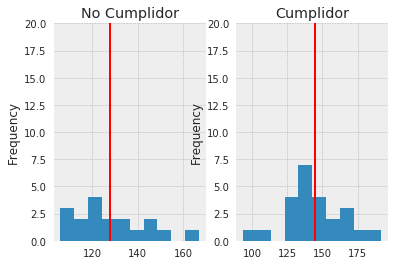

MEDIA_TAD
   LABEL       mean        std  count
0    0.0  82.333333  11.757351   18.0
1    1.0  90.500000  16.376680   24.0
[ 2281.01446518] [ 0.] ['yes']
[ 47.75996718] [ 0.] ['yes']
0.0 5.2748148019e-16 ['yes']


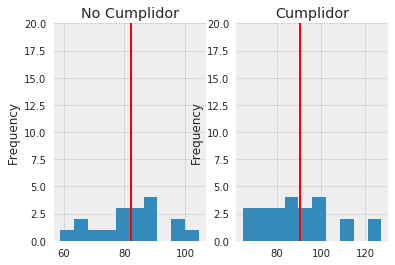

Sat O2
   LABEL       mean       std  count
0    0.0  97.888889  0.676400   18.0
1    1.0  97.083333  1.863066   24.0
[ 2699.91438152] [ 0.] ['yes']
[ 51.96070036] [ 0.] ['yes']
0.0 2.52724778698e-16 ['yes']


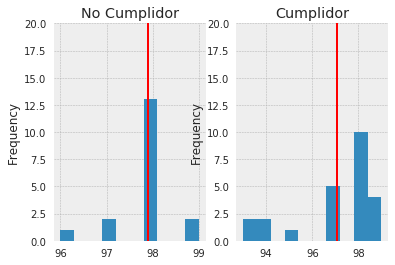

PRESS_CPAP
   LABEL       mean       std  count
0    0.0  10.800000  1.174233   18.0
1    1.0  11.016667  1.189690   24.0
[ 582.97275389] [ 0.] ['yes']
[ 24.14482872] [ 0.] ['yes']
0.0 4.0242574754e-16 ['yes']


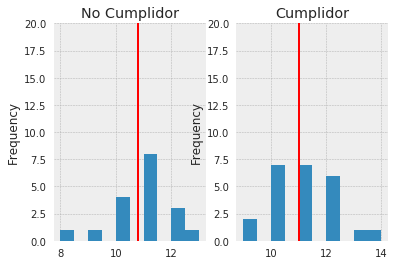

EPWORTH
   LABEL      mean       std  count
0    0.0  9.777778  4.399941   18.0
1    1.0  8.141667  4.893111   24.0
[ 154.91756869] [ 0.] ['yes']
[ 12.44658864] [ 0.] ['yes']
45.0 1.14754036346e-14 ['yes']


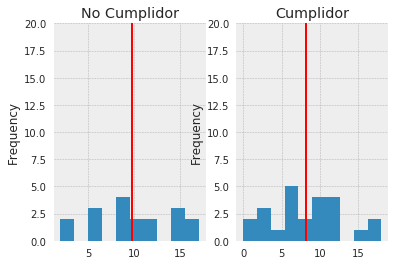

EUROQOL
   LABEL      mean       std  count
0    0.0  0.803606  0.219711   18.0
1    1.0  0.775005  0.224976   24.0
[ 0.00017894] [ 0.98935968] ['no']
[ 0.01337678] [ 0.98935968] ['no']
804.0 0.229130735702 ['no']


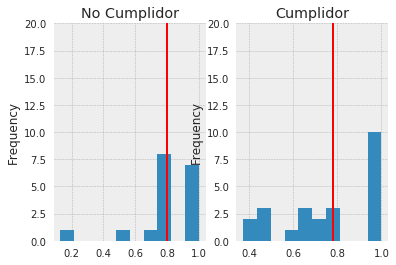

VISUAL
   LABEL       mean        std  count
0    0.0  65.555556  19.844164   18.0
1    1.0  52.541667  24.764946   24.0
[ 825.07555178] [ 0.] ['yes']
[ 28.72412839] [ 0.] ['yes']
0.0 4.42206307753e-16 ['yes']


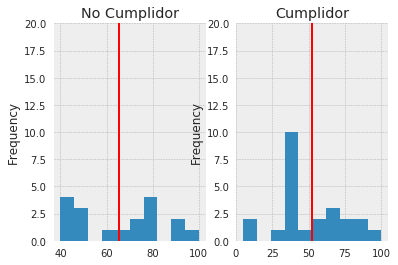

HORAS_USO_TOT_1
   LABEL        mean        std  count
0    0.0  175.002924  81.786604   18.0
1    1.0  249.695175  94.042331   24.0
[ 1376.89529369] [ 0.] ['yes']
[ 37.10653977] [ 0.] ['yes']
0.0 5.2748148019e-16 ['yes']


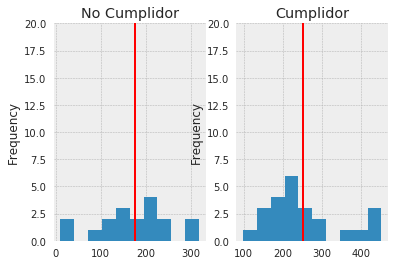

HORAS_USO_MED_NOCHE_1
   LABEL      mean       std  count
0    0.0  4.439912  1.514496   18.0
1    1.0  6.189145  1.343027   24.0
[ 174.99686727] [ 0.] ['yes']
[ 13.22863815] [ 0.] ['yes']
24.0 2.90182507118e-15 ['yes']


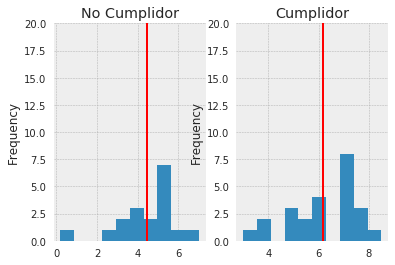

MEDIA_TAS_1
   LABEL        mean        std  count
0    0.0  128.201201  16.895427   18.0
1    1.0  136.670045  18.662613   24.0
[ 2905.00726226] [ 0.] ['yes']
[ 53.89811928] [ 0.] ['yes']
0.0 5.25680893096e-16 ['yes']


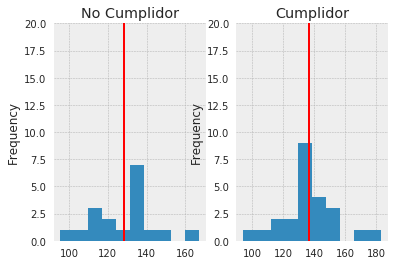

MEDIA_TAD_1
   LABEL       mean        std  count
0    0.0  80.546547  10.783487   18.0
1    1.0  83.870495  12.457628   24.0
[ 2272.36556005] [ 0.] ['yes']
[ 47.66933564] [ 0.] ['yes']
0.0 5.17649453348e-16 ['yes']


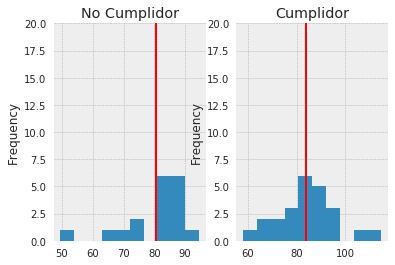

EPWORTH_1
   LABEL      mean       std  count
0    0.0  7.622515  3.643109   18.0
1    1.0  4.902851  2.995468   24.0
[ 111.21517944] [ 0.] ['yes']
[ 10.54586077] [ 0.] ['yes']
57.0 2.43624908943e-14 ['yes']


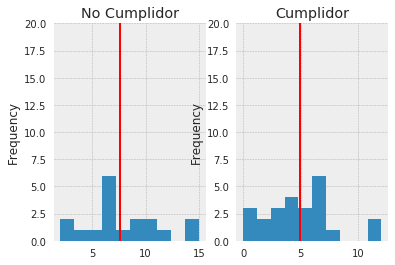

EUROQOL_1
   LABEL      mean       std  count
0    0.0  0.871226  0.111623   18.0
1    1.0  0.828685  0.150680   24.0
[ 0.25394752] [ 0.61566039] ['no']
[ 0.50393206] [ 0.61566039] ['no']
828.0 0.3058752055 ['no']


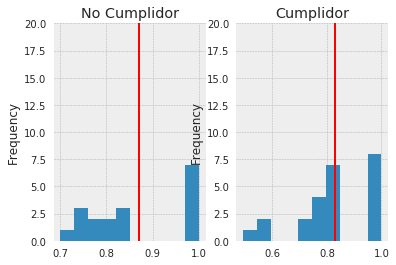

VISUAL_EUROQOL_1
   LABEL       mean        std  count
0    0.0  73.213213  13.376536   18.0
1    1.0  69.245495  19.323479   24.0
[ 1684.54331946] [ 0.] ['yes']
[ 41.04318847] [ 0.] ['yes']
0.0 4.8034678217e-16 ['yes']


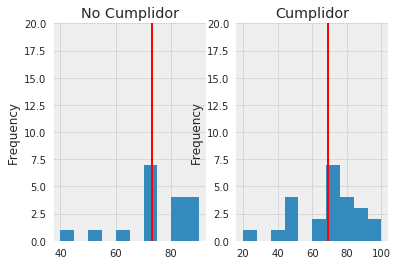

HORAS_USO_MED_NOCHE_3
   LABEL      mean       std  count
0    0.0  3.857444  1.607637   18.0
1    1.0  6.429167  1.113349   24.0
[ 154.8158953] [ 0.] ['yes']
[ 12.44250358] [ 0.] ['yes']
48.0 1.64427314338e-14 ['yes']


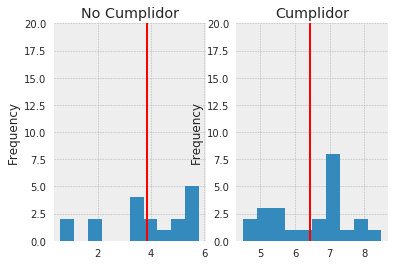

MEDIA TAS_3
   LABEL        mean        std  count
0    0.0  129.452485  15.595162   18.0
1    1.0  137.203399  20.233669   24.0
[ 2895.72941194] [ 0.] ['yes']
[ 53.81198205] [ 0.] ['yes']
0.0 5.26400434104e-16 ['yes']


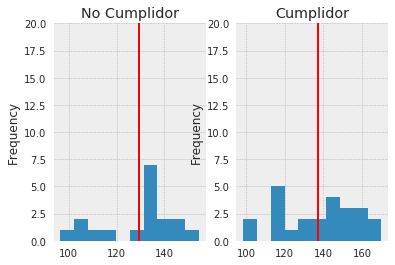

MEDIA TAD_3
   LABEL       mean        std  count
0    0.0  80.657479  10.461752   18.0
1    1.0  81.743750  16.123028   24.0
[ 2141.0368754] [ 0.] ['yes']
[ 46.27133968] [ 0.] ['yes']
0.0 5.26940696779e-16 ['yes']


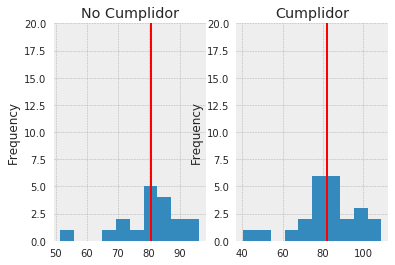

EPWORTH_3
   LABEL      mean       std  count
0    0.0  7.986667  4.235603   18.0
1    1.0  4.300000  2.430960   24.0
[ 117.37435584] [ 0.] ['yes']
[ 10.83394461] [ 0.] ['yes']
36.0 5.10963515281e-15 ['yes']


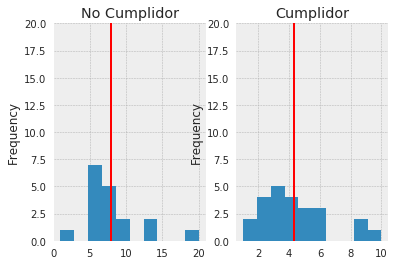

EUROQOL_3
   LABEL      mean       std  count
0    0.0  0.833600  0.206254   18.0
1    1.0  0.839017  0.186306   24.0
[ 0.14750444] [ 0.70192582] ['no']
[ 0.38406306] [ 0.70192582] ['no']
780.0 0.163167791054 ['no']


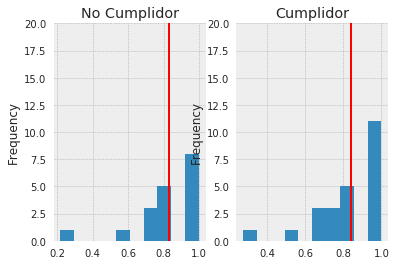

VISUAL EUROQOL_3
   LABEL       mean        std  count
0    0.0  72.132051  12.482647   18.0
1    1.0  71.355769  23.535781   24.0
[ 852.40077361] [ 0.] ['yes']
[ 29.19590337] [ 0.] ['yes']
24.0 2.55271409586e-15 ['yes']


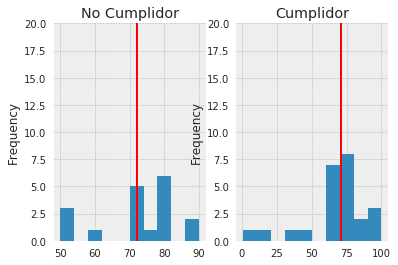

In [224]:
from scipy import stats
mat = []
sigArr = []
for i in range(len(catCols)):
    if catCols[i] == 0:

        r, p = f_oneway(np.log((dfImputed.iloc[:,i].values.astype(float)+1.0).reshape(-1,1)),dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r1, p1 = stats.ttest_ind(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))        
        r2, p2 = stats.mannwhitneyu(dfImputed.iloc[:,i].values.astype(float),
                                    dfImputed["LABEL"].values.astype(int))
                    
        data = dfImputed[["LABEL",dfImputed.columns[i]]].groupby(["LABEL"]).agg({"std","mean","count"}).iloc[:,:4].reset_index()
        data = pd.DataFrame(data.values, columns=["LABEL","std","count","mean"])

        #Save results
        feat = dfImputed.columns[i]
        val_c0 = data[data["LABEL"]==0.0]["count"].iloc[0]
        val_m0 = round(data[data["LABEL"]==0.0]["mean"].iloc[0],2)
        val_s0 = round(data[data["LABEL"]==0.0]["std"].iloc[0],2)
        val_c1 = round(data[data["LABEL"]==1.0]["count"].iloc[0],2)
        val_m1 = round(data[data["LABEL"]==1.0]["mean"].iloc[0],2)
        val_s1 = round(data[data["LABEL"]==1.0]["std"].iloc[0],2)
        
        sigArr.append([feat, 
                       str(val_m0) + "+/-" + str(val_s0), 
                       str(val_m1) + "+/-" + str(val_s1), 
                       r2, p2,
                       "yes" if p2 < 0.05 else "no", 
                       "yes" if p2 < 0.01 else "no",
                       "yes" if p2 < 0.001 else "no",
                       "num"])
            
        print feat        
        print data.loc[:,["LABEL","mean","std","count"]]
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]            
        print r2, p2, ["yes" if p2 < 0.05 else "no"]         

        ax = plt.subplot(1,2,1)
        dfImputed[dfImputed.LABEL == 0][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.axvline(val_m0, c="r")
        ax.set_ylim(0,20)
        ax.set_title("No Cumplidor")
        
        ax = plt.subplot(1,2,2)
        dfImputed[dfImputed.LABEL == 1][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.axvline(val_m1, c="r")
        ax.set_ylim(0,20)
        ax.set_title("Cumplidor")
        plt.show()
        
dfDescNum = pd.DataFrame(sigArr, columns=["feature","non_compliant","compliant","r","p_value","p<0.05","p<0.01","p<0.001","type"])        

In [225]:
print "Total Numeric features:", dfDescNum.shape[0], 
print "Statistically significant:", dfDescNum[dfDescNum["p_value"] < 0.05].shape[0]

pd.set_option('display.max_rows', 500)
dfDescNum[dfDescNum.p_value < 0.05].sort_values("p_value",ascending=True)

Total Numeric features: 32 Statistically significant: 26


,feature,non_compliant,compliant,r,p_value,p<0.05,p<0.01,p<0.001,type
14,Sat O2,97.89+/-0.68,97.08+/-1.86,0.0,2.527248e-16,yes,yes,yes,num
15,PRESS_CPAP,10.8+/-1.17,11.02+/-1.19,0.0,4.024257e-16,yes,yes,yes,num
18,VISUAL,65.56+/-19.84,52.54+/-24.76,0.0,4.422063e-16,yes,yes,yes,num
25,VISUAL_EUROQOL_1,73.21+/-13.38,69.25+/-19.32,0.0,4.803468e-16,yes,yes,yes,num
11,CIRC_CUELLO,42.61+/-5.11,42.46+/-3.69,0.0,5.097334e-16,yes,yes,yes,num
22,MEDIA_TAD_1,80.55+/-10.78,83.87+/-12.46,0.0,5.176495e-16,yes,yes,yes,num
9,TALLA,1.66+/-0.1,1.68+/-0.1,0.0,5.244239e-16,yes,yes,yes,num
21,MEDIA_TAS_1,128.2+/-16.9,136.67+/-18.66,0.0,5.256809e-16,yes,yes,yes,num
0,EDAD,51.67+/-12.06,60.88+/-11.69,0.0,5.256809e-16,yes,yes,yes,num
27,MEDIA TAS_3,129.45+/-15.6,137.2+/-20.23,0.0,5.264004e-16,yes,yes,yes,num
